## SME: BJ goods and competitive banks with reserve requirement

## System of equations

Given $\gamma=1+\tau$ and $i_r$

**Money demand**

$$
\frac{\gamma}{\beta}=1+\mathcal{R}(z,\mathbf{s})
$$

where the return on real money balance, $\mathcal{R}(z,\mathbf{s})$, is defined as:

$$
\mathcal{R}(z,\mathbf{s}) = 
\begin{cases}
    \int_{\underline{\rho}}^{\overline{\rho}} \left[ \frac{u_{q}[q(z,\rho,\mathbf{s})]}{\rho} - 1 \right] \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s}) & \text{if } i = i_{d} \\
    \\
    \begin{aligned}
        & (1-n)i_{d} + n \int_{\underline{\rho}}^{\tilde{\rho}_{i}} i \cdot \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s}) \\
        & + n \int_{\tilde{\rho}_{i}}^{\hat{\rho}_{i_{d}}} \left\{ \sum_{\ell=1}^{2}\omega_{\ell}(\rho,z,\mathbf{s}) \cdot \left[ \left( \frac{u_{q}(z/\rho_{\ell,\rho})}{\rho_{\ell,\rho}} \right) \mathbf{1}_{\{\rho_{\ell,\rho}\in(\tilde{\rho}_{i},\hat{\rho}_{i_{d}}]\}} - 1 \right] \right\} \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s}) \\
        & + n \int_{\hat{\rho}_{i_{d}}}^{\overline{\rho}} i_{d} \cdot \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s})
    \end{aligned} & \text{if } i > i_{d}
\end{cases}
$$

and where $\varrho(\rho,z,\mathbf{s}) := \alpha_{1}+2\alpha_{2}(1-J(\rho,z,\mathbf{s}))$, and

$$
\omega_{\ell}(\rho,z,\mathbf{s}) := \left(\mathbf{1}_{\{ L(\rho)\neq\emptyset \}} \cdot \pi_{\ell,\rho}\right) + \mathbf{1}_{\{ L(\rho)=\emptyset \text{ and } \rho_{\ell,\rho}=\rho \}}
$$
for $\ell \in \{1, 2\}$, where $\rho \sim J(\cdot,z,\mathbf{s})$.

**Loan Market Clearing**

Given $z=z^{\star}=Z, i=\bar{i}_{r}=i_{}^{\star}$ clears the loan market,

$$
\underbrace{ (1-\chi\cdot\mathbf{1}_{\{ i>i_{d}>i_{r}\} }) \left[ (1-n)z + n\int_{\underline{\rho}_{i}}^{\overline{\rho}}\delta^{\star}(\rho,i_{d},z)\,\text{d}\hat{J}(\rho,z,\mathbf{s}) \right] }_{=:D(\bar{i}_{r}), \text{ total deposits}} = \underbrace{ n\int_{\underline{\rho}}^{\tilde{\rho}_{i}}\xi^{\star}(\rho,i,z)\,\text{d}\hat{J}(\rho,z,\mathbf{s}) }_{=:L(\bar{i}_{r}), \text{ total loans}}
$$

#### This Jupyter notebook reports the equilibrium outcomes in the SME.

- First, it provides detailed calculations of the CEV (Consumption Equivalent Variation).
- Additionally, it examines how real balances($z$), interest rates($i$), markup($\mu$), and markup dispersion($CV_{\mu}$) change with inflation.

- The main figure, Figure 4. 'Consumption Equivalent Variation (%)' of transitioning from the no-bank HLMW economy to the baseline economy with banking." 

In [1]:
import bj_bcw as main
import hlmw as hlmw
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import interpolate
from scipy.optimize import brentq, fsolve
#import tikzplotlib
import time

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

In [3]:
font = {'family' : 'serif','weight':'normal',
        'size'   : 10}
plt.rc('font', **font)

In [4]:
σ_DM=0.283
Ubar_CM=1.8000
n=0.65
α_1=0.05
β=0.981
τ_min=β-1
τ_max = 0.1
τgrid_size = 60

In [5]:
model = main.baseline_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min,i_r=0,chi=0.007,N_reimann = 1000)

model_hlmw =hlmw.hlmw_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min,N_reimann = 1000)

### SME: HLMW + perfectly competitive banks (Baseline)

* Vary $\tau \in [\beta-1, 0.1]$

In [6]:
z_guess = 0.7
i_guess = 0.01
result = model.SME_stat(z_guess, i_guess) # this uses fsolve

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

1.0000000000000078
-7.6938214625393e-15
0.8888888888888526
0.11111111111114721
0.7777777777778068
0.2222222222221933
0.6666666666666217
0.3333333333333782
0.5555555555555269
0.44444444444447306
0.44444444444440206
0.555555555555598
0.33333333333332593
0.6666666666666741
0.22222222222220103
0.777777777777799
0.1111111111110761
0.8888888888889239
0.0
1.0
1.0000000000000078
-7.6938214625393e-15
0.8888888888888526
0.11111111111114721
0.7777777777778068
0.2222222222221933
0.6666666666666217
0.3333333333333782
0.5555555555555269
0.44444444444447306
0.44444444444440206
0.555555555555598
0.33333333333332593
0.6666666666666741
0.22222222222220103
0.777777777777799
0.1111111111110761
0.8888888888889239
0.0
1.0
1.0000000000000078
-7.6938214625393e-15
0.8888888888888526
0.11111111111114721
0.7777777777778068
0.2222222222221933
0.6666666666666217
0.3333333333333782
0.5555555555555269
0.44444444444447306
0.44444444444440206
0.555555555555598
0.33333333333332593
0.6666666666666741
0.22222222222220103

0.9999999999999972
2.7704102011839445e-15
0.8999999999999976
0.10000000000000249
0.7999999999999978
0.20000000000000223
0.700000000000025
0.299999999999975
0.5999999999999983
0.4000000000000017
0.4999999999999987
0.5000000000000013
0.3999999999999989
0.6000000000000011
0.3000000000000262
0.6999999999999739
0.1999999999999994
0.8000000000000006
0.09999999999999976
0.9000000000000002
0.0
1.0
0.9999999999999972
2.7704102011839445e-15
0.8999999999999976
0.10000000000000249
0.7999999999999978
0.20000000000000223
0.700000000000025
0.299999999999975
0.5999999999999983
0.4000000000000017
0.4999999999999987
0.5000000000000013
0.3999999999999989
0.6000000000000011
0.3000000000000262
0.6999999999999739
0.1999999999999994
0.8000000000000006
0.09999999999999976
0.9000000000000002
0.0
1.0
0.9999999999999972
2.7704102011839445e-15
0.8999999999999976
0.10000000000000249
0.7999999999999978
0.20000000000000223
0.700000000000025
0.299999999999975
0.5999999999999983
0.4000000000000017
0.4999999999999987
0

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
0.9999999999999991
9.717538408759766e-16
0.9333333333333228
0.06666666666667719
0.8666666666666948
0.13333333333330538
0.8000000000000004
0.1999999999999996
0.7333333333333243
0.2666666666666758
0.666666666

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

1.0000000000000056
-5.5621814635580985e-15
0.9375000000000034
0.06249999999999652
0.8750000000000183
0.12499999999998172
0.8124999999999879
0.18750000000001216
0.7500000000000028
0.24999999999999736
0.6874999999999837
0.3125000000000163
0.6249999999999986
0.3750000000000015
0.5625000000000134
0.43749999999998673
0.49999999999999434
0.5000000000000057
0.4375000000000091
0.5624999999999909
0.3750000000000239
0.6249999999999761
0.3125000000000219
0.6874999999999781
0.25000000000001976
0.7499999999999802
0.18750000000003458
0.8124999999999655
0.1250000000000494
0.8749999999999507
0.06250000000003042
0.9374999999999696
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0

1.0000000000000073
-7.220622520820354e-15
0.9411764705882437
0.05882352941175633
0.8823529411764801
0.11764705882351988
0.8235294117647166
0.17647058823528344
0.764705882352953
0.235294117647047
0.7058823529411467
0.2941176470588533
0.647058823529426
0.35294117647057405
0.5882352941176195
0.4117647058823804
0.5294117647058988
0.47058823529410115
0.4705882352941085
0.5294117647058916
0.4117647058823718
0.5882352941176282
0.3529411764705654
0.6470588235294346
0.2941176470588447
0.7058823529411553
0.23529411764705424
0.7647058823529458
0.17647058823529072
0.8235294117647093
0.11764705882352712
0.8823529411764729
0.05882352941176361
0.9411764705882364
0.0
1.0
1.0000000000000073
-7.220622520820354e-15
0.9411764705882437
0.05882352941175633
0.8823529411764801
0.11764705882351988
0.8235294117647166
0.17647058823528344
0.764705882352953
0.235294117647047
0.7058823529411467
0.2941176470588533
0.647058823529426
0.35294117647057405
0.5882352941176195
0.4117647058823804
0.5294117647058988
0.470588

0.9444444444444501
0.05555555555554984
0.8888888888888852
0.11111111111111477
0.8333333333333504
0.16666666666664962
0.7777777777777598
0.22222222222224008
0.7222222222222251
0.2777777777777749
0.6666666666666752
0.33333333333332477
0.6111111111111253
0.3888888888888747
0.5555555555555499
0.44444444444445014
0.5
0.5
0.44444444444445
0.5555555555555499
0.38888888888890016
0.6111111111110998
0.3333333333333098
0.6666666666666902
0.277777777777775
0.722222222222225
0.22222222222221
0.7777777777777899
0.16666666666667504
0.8333333333333249
0.11111111111108467
0.8888888888889153
0.055555555555549925
0.9444444444444501
0.0
1.0
0.9444444444444501
0.05555555555554984
0.8888888888888852
0.11111111111111477
0.8333333333333504
0.16666666666664962
0.7777777777777598
0.22222222222224008
0.7222222222222251
0.2777777777777749
0.6666666666666752
0.33333333333332477
0.6111111111111253
0.3888888888888747
0.5555555555555499
0.44444444444445014
0.5
0.5
0.44444444444445
0.5555555555555499
0.388888888888900

1.0000000000000018
-1.6561750455499673e-15
0.9473684210526205
0.05263157894737939
0.894736842105264
0.105263157894736
0.8421052631578829
0.15789473684211705
0.7894736842105018
0.2105263157894981
0.7368421052631453
0.2631578947368547
0.6842105263157786
0.31578947368422144
0.6315789473684075
0.3684210526315924
0.5789473684210409
0.42105263157895917
0.5263157894736842
0.47368421052631576
0.4736842105263031
0.5263157894736968
0.42105263157892214
0.5789473684210779
0.3684210526315655
0.6315789473684345
0.31578947368419874
0.6842105263158013
0.2631578947368421
0.7368421052631579
0.2105263157894611
0.7894736842105389
0.15789473684207997
0.84210526315792
0.10526315789472347
0.8947368421052765
0.052631578947342335
0.9473684210526576
0.0
1.0
1.0000000000000018
-1.6561750455499673e-15
0.9473684210526205
0.05263157894737939
0.894736842105264
0.105263157894736
0.8421052631578829
0.15789473684211705
0.7894736842105018
0.2105263157894981
0.7368421052631453
0.2631578947368547
0.6842105263157786
0.3157

1.0000000000000073
-7.148330866963303e-15
0.9500000000000091
0.04999999999999088
0.9000000000000111
0.09999999999998889
0.8500000000000132
0.14999999999998692
0.800000000000015
0.19999999999998494
0.750000000000017
0.24999999999998296
0.7000000000000054
0.29999999999999455
0.6500000000000348
0.3499999999999654
0.6000000000000367
0.39999999999996344
0.5500000000000249
0.4499999999999751
0.5000000000000036
0.4999999999999965
0.45000000000000556
0.5499999999999945
0.40000000000000746
0.5999999999999925
0.3500000000000094
0.6499999999999906
0.30000000000002514
0.699999999999975
0.2500000000000271
0.749999999999973
0.2000000000000154
0.7999999999999846
0.15000000000001742
0.8499999999999825
0.10000000000001938
0.8999999999999806
0.049999999999997935
0.9500000000000021
0.0
1.0
0.9999999999999933
6.68717195514839e-15
0.9499999999999856
0.05000000000001421
0.9000000000000054
0.09999999999999455
0.8499999999999608
0.15000000000003905
0.7999999999999806
0.20000000000001938
0.7499999999999867
0.2

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999933
6.729744357332291e-15
0.9523809523809372
0.04761904761906263
0.9047619047618813
0.09523809523811853
0.8571428571428609
0.14285714285713902
0.809523809523805
0.1904761904761949
0.7619047619047491
0.2380952380952508
0.7142857142856932
0.2857142857143067
0.6666666666666634
0.33333333333333665
0.6190476190475944
0.3809523809524055
0.5714285714285384
0.42857142857146147
0.523809523809531
0.47619047619046895
0.47619047619047516
0.5238095238095248
0.4285714285714193
0.5714285714285807
0.3809523809523632
0.6190476190476367
0.3333333333333204
0.6666666666666796
0.28571428571428703
0.714285714285713
0.23809523809524408
0.761904761904756
0.19047619047618816
0.8095238095238119
0.14285714285713225
0.8571428571428678
0.09523809523808942
0.9047619047619107
0.04761904761903351
0.9523809523809665
0.0
1.0
0.9999999999999933
6.729744357332291e-15
0.9523809523809372
0.04761904761906263
0.9047619047618813
0.09523809523811853
0.8571428571428609
0.14285714285713902
0.809523809523805
0.1904

1.000000000000002
-1.9702415164215423e-15
0.9545454545454691
0.04545454545453079
0.9090909090909024
0.09090909090909757
0.8636363636363698
0.13636363636363033
0.8181818181818153
0.1818181818181847
0.77272727272727
0.22727272727272987
0.7272727272727498
0.2727272727272502
0.6818181818181831
0.31818181818181696
0.6363636363636502
0.36363636363634977
0.590909090909071
0.40909090909092893
0.5454545454545507
0.45454545454544926
0.49999999999997136
0.5000000000000285
0.4545454545454512
0.5454545454545487
0.40909090909090595
0.5909090909090939
0.3636363636363516
0.6363636363636483
0.31818181818180635
0.6818181818181935
0.272727272727252
0.7272727272727479
0.22727272727270673
0.7727272727272931
0.18181818181815246
0.8181818181818474
0.13636363636361976
0.8636363636363802
0.090909090909087
0.909090909090913
0.04545454545453263
0.9545454545454674
0.0
1.0
1.000000000000002
-1.9702415164215423e-15
0.9545454545454691
0.04545454545453079
0.9090909090909024
0.09090909090909757
0.8636363636363698
0.13

1.0000000000000007
-7.307467908055212e-16
0.954545454545443
0.04545454545455677
0.9090909090908984
0.09090909090910154
0.8636363636363535
0.13636363636364632
0.8181818181818311
0.1818181818181688
0.7727272727272864
0.22727272727271358
0.7272727272727416
0.27272727272725833
0.6818181818181969
0.31818181818180313
0.6363636363636521
0.3636363636363479
0.5909090909090945
0.4090909090909054
0.5454545454545497
0.45454545454545014
0.500000000000005
0.49999999999999495
0.45454545454546025
0.5454545454545396
0.40909090909091556
0.5909090909090844
0.36363636363637075
0.6363636363636292
0.318181818181826
0.681818181818174
0.2727272727272685
0.7272727272727314
0.22727272727272368
0.7727272727272763
0.18181818181817883
0.8181818181818211
0.1363636363636341
0.8636363636363659
0.09090909090908947
0.9090909090909105
0.045454545454531876
0.954545454545468
0.0
1.0
1.0000000000000016
-1.5277714874457829e-15
0.9545454545454394
0.04545454545456055
0.9090909090909116
0.09090909090908839
0.8636363636363837
0

1.000000000000004
-3.980751565928034e-15
0.9545454545454439
0.045454545454556086
0.9090909090908964
0.0909090909091037
0.8636363636363704
0.13636363636362953
0.8181818181818229
0.18181818181817713
0.7727272727272628
0.2272727272727372
0.727272727272737
0.27272727272726305
0.6818181818181769
0.31818181818182306
0.6363636363636292
0.3636363636363707
0.5909090909091035
0.40909090909089657
0.545454545454556
0.45454545454544415
0.5000000000000083
0.49999999999999173
0.45454545454546064
0.5454545454545394
0.4090909090909224
0.5909090909090776
0.36363636363636226
0.6363636363636377
0.31818181818181457
0.6818181818181854
0.2727272727272888
0.7272727272727112
0.2272727272727413
0.7727272727272587
0.18181818181819362
0.8181818181818065
0.13636363636362095
0.863636363636379
0.0909090909091076
0.9090909090908924
0.0454545454545476
0.9545454545454524
0.0
1.0
1.000000000000004
-3.980751565928034e-15
0.9545454545454439
0.045454545454556086
0.9090909090908964
0.0909090909091037
0.8636363636363704
0.13

1.000000000000005
-4.957112919468063e-15
0.9565217391304313
0.043478260869568845
0.9130434782608905
0.08695652173910969
0.8695652173913047
0.13043478260869543
0.8260869565217398
0.17391304347826017
0.7826086956521662
0.21739130434783394
0.7391304347826133
0.26086956521738675
0.6956521739130275
0.30434782608697253
0.6521739130434867
0.34782608695651335
0.608695652173901
0.3913043478260991
0.5652173913043482
0.43478260869565183
0.5217391304347835
0.4782608695652166
0.4782608695652096
0.5217391304347904
0.43478260869565677
0.5652173913043432
0.391304347826071
0.608695652173929
0.34782608695651823
0.6521739130434817
0.3043478260869565
0.6956521739130436
0.2608695652173917
0.7391304347826083
0.21739130434780587
0.782608695652194
0.173913043478253
0.8260869565217469
0.1304347826086793
0.8695652173913206
0.08695652173912645
0.9130434782608735
0.043478260869561844
0.956521739130438
0.0
1.0
1.000000000000005
-4.957112919468063e-15
0.9565217391304313
0.043478260869568845
0.9130434782608905
0.086

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
1.000000000000007
-7.049305035593732e-15
0.9583333333333445
0.04166666666665566
0.9166666666666817
0.08333333333331837
0.875000000000031
0.12499999999996919
0.8333333333333353
0.16666666666666477
0.79166666

0.9583333333333246
0.04166666666667531
0.9166666666666493
0.08333333333335062
0.8749999999999855
0.12500000000001446
0.8333333333333102
0.16666666666668978
0.7916666666666783
0.2083333333333218
0.7499999999999913
0.2500000000000086
0.708333333333316
0.2916666666666839
0.6666666666666522
0.33333333333334775
0.6249999999999769
0.37500000000002304
0.583333333333345
0.41666666666665503
0.5416666666666696
0.4583333333333304
0.4999999999999942
0.5000000000000058
0.45833333333333043
0.5416666666666695
0.41666666666664354
0.5833333333333564
0.37499999999997974
0.6250000000000202
0.3333333333333362
0.6666666666666637
0.2916666666666609
0.708333333333339
0.2499999999999972
0.7500000000000028
0.20833333333332177
0.7916666666666782
0.16666666666667834
0.8333333333333216
0.12500000000001457
0.8749999999999855
0.08333333333333924
0.9166666666666607
0.041666666666663806
0.9583333333333361
0.0
1.0
0.9583333333333246
0.04166666666667531
0.9166666666666493
0.08333333333335062
0.8749999999999855
0.125000

0.16666666666664964
0.8333333333333502
0.12499999999997562
0.8750000000000242
0.08333333333332477
0.9166666666666752
0.04166666666663922
0.9583333333333606
0.0
1.0
0.9999999999999991
8.98286172269437e-16
0.958333333333325
0.04166666666667484
0.9166666666666626
0.08333333333333724
0.8750000000000003
0.12499999999999967
0.8333333333333379
0.16666666666666208
0.791666666666664
0.20833333333333598
0.7500000000000016
0.24999999999999842
0.7083333333333275
0.29166666666667235
0.6666666666666652
0.33333333333333476
0.6250000000000028
0.37499999999999717
0.5833333333333404
0.4166666666666596
0.5416666666666663
0.45833333333333354
0.5000000000000157
0.4999999999999844
0.4583333333333416
0.5416666666666584
0.41666666666666763
0.5833333333333323
0.3750000000000053
0.6249999999999947
0.33333333333334286
0.6666666666666571
0.29166666666668034
0.7083333333333196
0.24999999999998593
0.750000000000014
0.20833333333331194
0.791666666666688
0.16666666666664964
0.8333333333333502
0.12499999999997562
0.87

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
0.999999999999998
2.0137216145281405e-15
0.9599999999999953
0.04000000000000472
0.9199999999999925
0.08000000000000744
0.8799999999999898
0.12000000000001015
0.8399999999999989
0.16000000000000122
0.7999999

1.000000000000004
-3.910065088853568e-15
0.9600000000000231
0.039999999999977116
0.9199999999999999
0.08000000000000018
0.8800000000000077
0.11999999999999232
0.8399999999999958
0.16000000000000428
0.8000000000000036
0.1999999999999964
0.7600000000000116
0.23999999999998853
0.7200000000000194
0.27999999999998065
0.6799999999999963
0.3200000000000037
0.6400000000000153
0.3599999999999848
0.6000000000000034
0.3999999999999967
0.5599999999999999
0.44
0.5200000000000191
0.479999999999981
0.479999999999996
0.520000000000004
0.44000000000000383
0.5599999999999962
0.4000000000000117
0.5999999999999883
0.3599999999999886
0.6400000000000113
0.32000000000000767
0.6799999999999924
0.28000000000002667
0.7199999999999734
0.24000000000000363
0.7599999999999965
0.20000000000001145
0.7999999999999886
0.16000000000000822
0.8399999999999918
0.11999999999999619
0.8800000000000038
0.08000000000000417
0.9199999999999958
0.040000000000012005
0.959999999999988
0.0
1.0
1.000000000000004
-3.910065088853568e-15

1.0000000000000004
-3.6150867723000276e-16
0.9615384615384744
0.03846153846152561
0.9230769230769291
0.07692307692307082
0.8846153846153733
0.11538461538462674
0.8461538461538688
0.15384615384613132
0.8076923076923127
0.19230769230768724
0.7692307692307783
0.23076923076922176
0.7307692307692415
0.26923076923075845
0.6923076923076963
0.30769230769230366
0.6538461538461511
0.34615384615384887
0.6153846153846251
0.3846153846153748
0.5769230769230907
0.4230769230769093
0.5384615384615347
0.46153846153846523
0.5000000000000194
0.4999999999999805
0.4615384615384743
0.5384615384615257
0.4230769230769399
0.5769230769230602
0.38461538461538375
0.6153846153846162
0.34615384615385775
0.6538461538461422
0.30769230769231254
0.6923076923076874
0.26923076923076733
0.7307692307692326
0.23076923076925218
0.7692307692307478
0.1923076923076961
0.8076923076923038
0.15384615384616177
0.8461538461538383
0.11538461538460568
0.8846153846153942
0.07692307692309064
0.9230769230769094
0.03846153846153446
0.96153

0.9999999999999953
4.546254245615062e-15
0.9615384615384683
0.03846153846153156
0.9230769230769306
0.07692307692306927
0.8846153846153736
0.11538461538462623
0.8461538461538467
0.15384615384615324
0.8076923076923198
0.19230769230768024
0.7692307692307627
0.2307692307692372
0.730769230769225
0.26923076923077494
0.692307692307698
0.30769230769230194
0.6538461538461411
0.34615384615385886
0.6153846153846141
0.3846153846153859
0.576923076923087
0.42307692307691297
0.5384615384615301
0.4615384615384699
0.5000000000000032
0.4999999999999969
0.4615384615384653
0.5384615384615347
0.4230769230769084
0.5769230769230915
0.3846153846153815
0.6153846153846185
0.34615384615384365
0.6538461538461563
0.3076923076922975
0.6923076923077025
0.2692307692307705
0.7307692307692295
0.23076923076924347
0.7692307692307566
0.19230769230768646
0.8076923076923136
0.15384615384614864
0.8461538461538514
0.11538461538462168
0.8846153846153784
0.07692307692306478
0.9230769230769352
0.038461538461526966
0.961538461538

0.9999999999999967
3.294027476051774e-15
0.9615384615384586
0.03846153846154138
0.9230769230769205
0.07692307692307947
0.8846153846153932
0.11538461538460676
0.8461538461538248
0.1538461538461751
0.8076923076922976
0.1923076923077024
0.7692307692307596
0.23076923076924047
0.7307692307692215
0.26923076923077854
0.6923076923076833
0.30769230769231665
0.6538461538461453
0.34615384615385475
0.6153846153846071
0.38461538461539285
0.57692307692308
0.4230769230769201
0.538461538461531
0.46153846153846895
0.49999999999999284
0.5000000000000071
0.46153846153845474
0.5384615384615452
0.42307692307692757
0.5769230769230724
0.38461538461538947
0.6153846153846105
0.34615384615385136
0.6538461538461486
0.30769230769231337
0.6923076923076866
0.2692307692307752
0.7307692307692247
0.2307692307692371
0.7692307692307628
0.19230769230769046
0.8076923076923096
0.15384615384615233
0.8461538461538477
0.11538461538462508
0.884615384615375
0.07692307692307611
0.9230769230769239
0.038461538461538006
0.961538461

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.2864881150161514e-15
0.9629629629629616
0.03703703703703843
0.9259259259259085
0.07407407407409153
0.8888888888888637
0.11111111111113611
0.8518518518518401
0.1481481481481598
0.814814814814806
0.18518518518519395
0.7777777777777718
0.22222222222222812
0.7407407407407482
0.2592592592592518
0.703703703703714
0.29629629629628595
0.666666666666661
0.33333333333333903
0.6296296296296269
0.3703703703703732
0.5925925925925927
0.40740740740740733
0.5555555555555586
0.4444444444444415
0.5185185185185244
0.48148148148147557
0.48148148148147124
0.5185185185185287
0.44444444444443715
0.5555555555555628
0.407407407407403
0.592592592592597
0.3703703703703689
0.6296296296296311
0.3333333333333452
0.6666666666666549
0.29629629629628157
0.7037037037037184
0.25925925925924737
0.7407407407407526
0.2222222222222238
0.7777777777777762
0.18518518518517907
0.8148148148148209
0.14814814814815547
0.8518518518518445
0.11111111111111086
0.8888888888888891
0.07407407407408717
0.9259259259259

0.9999999999999961
3.934071961049174e-15
0.9642857142856913
0.03571428571430852
0.9285714285714154
0.07142857142858455
0.8928571428571394
0.10714285714286059
0.8571428571428348
0.14285714285716516
0.8214285714285485
0.1785714285714513
0.7857142857142828
0.21428571428571724
0.7500000000000067
0.24999999999999328
0.7142857142857021
0.28571428571429786
0.678571428571426
0.3214285714285739
0.6428571428571399
0.35714285714286004
0.6071428571428455
0.3928571428571545
0.5714285714285695
0.42857142857143055
0.5357142857142833
0.4642857142857167
0.49999999999997863
0.5000000000000212
0.4642857142857027
0.5357142857142972
0.4285714285714266
0.5714285714285733
0.39285714285713214
0.6071428571428679
0.35714285714284605
0.6428571428571539
0.32142857142857
0.6785714285714299
0.2857142857142837
0.7142857142857162
0.24999999999998943
0.7500000000000105
0.21428571428571327
0.7857142857142867
0.17857142857143737
0.8214285714285626
0.14285714285713277
0.8571428571428672
0.10714285714285664
0.892857142857

0.9999999999999986
1.5344813745813994e-15
0.9642857142857075
0.03571428571429238
0.928571428571425
0.0714285714285749
0.8928571428571342
0.10714285714286574
0.8571428571428518
0.14285714285714826
0.821428571428561
0.1785714285714391
0.7857142857142784
0.2142857142857216
0.7499999999999876
0.2500000000000125
0.714285714285705
0.28571428571429497
0.6785714285714142
0.32142857142858583
0.6428571428571418
0.3571428571428582
0.6071428571428408
0.39285714285715917
0.5714285714285684
0.4285714285714316
0.5357142857142777
0.4642857142857224
0.4999999999999849
0.5000000000000151
0.4642857142857125
0.5357142857142875
0.4285714285714218
0.5714285714285783
0.3928571428571391
0.6071428571428609
0.3571428571428484
0.6428571428571517
0.32142857142856585
0.6785714285714342
0.2857142857142751
0.714285714285725
0.24999999999999245
0.7500000000000075
0.21428571428570156
0.7857142857142985
0.17857142857141903
0.821428571428581
0.14285714285712828
0.8571428571428718
0.10714285714285593
0.8928571428571441
0

0.9999999999999964
3.4389139796267293e-15
0.9642857142856914
0.03571428571430848
0.9285714285714152
0.07142857142858478
0.8928571428571286
0.10714285714287121
0.8571428571428339
0.14285714285716608
0.8214285714285576
0.1785714285714424
0.7857142857142814
0.2142857142857187
0.7499999999999949
0.2500000000000051
0.7142857142856898
0.2857142857143101
0.6785714285714135
0.32142857142858644
0.6428571428571372
0.35714285714286276
0.6071428571428508
0.3928571428571491
0.5714285714285559
0.4285714285714441
0.5357142857142796
0.46428571428572035
0.5000000000000033
0.49999999999999667
0.4642857142857169
0.535714285714283
0.4285714285714119
0.571428571428588
0.3928571428571355
0.6071428571428644
0.357142857142849
0.6428571428571509
0.32142857142855413
0.6785714285714458
0.285714285714278
0.714285714285722
0.2500000000000018
0.7499999999999982
0.21428571428571513
0.7857142857142848
0.1785714285714204
0.8214285714285796
0.14285714285713375
0.8571428571428662
0.10714285714285764
0.8928571428571423
0

0.999999999999995
5.0093239579577346e-15
0.9642857142857034
0.03571428571429652
0.9285714285714222
0.07142857142857789
0.8928571428571408
0.10714285714285926
0.8571428571428492
0.1428571428571508
0.8214285714285577
0.1785714285714423
0.7857142857142662
0.2142857142857338
0.7499999999999931
0.2500000000000067
0.7142857142857119
0.2857142857142881
0.6785714285714203
0.3214285714285796
0.642857142857139
0.357142857142861
0.6071428571428474
0.3928571428571525
0.5714285714285559
0.428571428571444
0.5357142857142746
0.4642857142857254
0.4999999999999933
0.5000000000000068
0.46428571428570176
0.5357142857142982
0.4285714285714102
0.5714285714285898
0.39285714285714746
0.6071428571428525
0.3571428571428558
0.6428571428571441
0.3214285714285745
0.6785714285714255
0.2857142857142727
0.7142857142857272
0.2499999999999915
0.7500000000000084
0.2142857142857
0.7857142857142999
0.1785714285714185
0.8214285714285815
0.142857142857127
0.857142857142873
0.10714285714286431
0.8928571428571357
0.071428571

1.0000000000000007
-7.790653496696604e-16
0.9655172413792973
0.034482758620702623
0.931034482758612
0.06896551724138791
0.8965517241379285
0.10344827586207166
0.8620689655172431
0.13793103448275695
0.8275862068965397
0.17241379310346033
0.7931034482758543
0.20689655172414564
0.7586206896551608
0.24137931034483923
0.7241379310344754
0.2758620689655245
0.6896551724137902
0.3103448275862098
0.6551724137930967
0.34482758620690335
0.6206896551724114
0.37931034482758863
0.5862068965517179
0.41379310344828224
0.5517241379310325
0.4482758620689675
0.5172413793103391
0.4827586206896611
0.4827586206896536
0.5172413793103464
0.44827586206895026
0.5517241379310498
0.41379310344827486
0.5862068965517252
0.3793103448275895
0.6206896551724105
0.344827586206886
0.655172413793114
0.3103448275862008
0.6896551724137991
0.27586206896550725
0.7241379310344928
0.24137931034483193
0.7586206896551682
0.20689655172411842
0.7931034482758815
0.17241379310345292
0.8275862068965472
0.13793103448274963
0.8620689655

1.0000000000000007
-7.790653496696604e-16
0.9655172413792973
0.034482758620702623
0.931034482758612
0.06896551724138791
0.8965517241379285
0.10344827586207166
0.8620689655172431
0.13793103448275695
0.8275862068965397
0.17241379310346033
0.7931034482758543
0.20689655172414564
0.7586206896551608
0.24137931034483923
0.7241379310344754
0.2758620689655245
0.6896551724137902
0.3103448275862098
0.6551724137930967
0.34482758620690335
0.6206896551724114
0.37931034482758863
0.5862068965517179
0.41379310344828224
0.5517241379310325
0.4482758620689675
0.5172413793103391
0.4827586206896611
0.4827586206896536
0.5172413793103464
0.44827586206895026
0.5517241379310498
0.41379310344827486
0.5862068965517252
0.3793103448275895
0.6206896551724105
0.344827586206886
0.655172413793114
0.3103448275862008
0.6896551724137991
0.27586206896550725
0.7241379310344928
0.24137931034483193
0.7586206896551682
0.20689655172411842
0.7931034482758815
0.17241379310345292
0.8275862068965472
0.13793103448274963
0.8620689655

1.0000000000000053
-5.418304768028275e-15
0.9655172413793246
0.034482758620675465
0.9310344827586353
0.06896551724136475
0.8965517241379362
0.1034482758620639
0.8620689655172652
0.13793103448273492
0.827586206896556
0.17241379310344396
0.7931034482758669
0.20689655172413324
0.7586206896551859
0.2413793103448141
0.7241379310344868
0.2758620689655133
0.6896551724138058
0.31034482758619414
0.6551724137931166
0.3448275862068835
0.6206896551724175
0.3793103448275826
0.5862068965517365
0.4137931034482635
0.5517241379310474
0.44827586206895276
0.5172413793103382
0.4827586206896618
0.48275862068965736
0.5172413793103426
0.4482758620689681
0.5517241379310319
0.4137931034482788
0.5862068965517213
0.3793103448275979
0.6206896551724022
0.34482758620689874
0.6551724137931013
0.3103448275861996
0.6896551724138005
0.2758620689655187
0.7241379310344813
0.24137931034481952
0.7586206896551805
0.2068965517241303
0.7931034482758698
0.17241379310344931
0.8275862068965507
0.13793103448276023
0.8620689655172

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999973
2.5866728135628376e-15
0.9666666666666623
0.03333333333333775
0.933333333333327
0.06666666666667292
0.9000000000000001
0.09999999999999987
0.8666666666666649
0.13333333333333502
0.8333333333333298
0.1666666666666702
0.799999999999985
0.20000000000001494
0.7666666666666498
0.23333333333335013
0.7333333333333325
0.2666666666666675
0.6999999999999974
0.30000000000000265
0.6666666666666525
0.3333333333333474
0.6333333333333174
0.3666666666666826
0.6000000000000001
0.39999999999999997
0.5666666666666649
0.4333333333333351
0.5333333333333201
0.4666666666666799
0.4999999999999849
0.5000000000000151
0.4666666666666675
0.5333333333333324
0.43333333333334223
0.5666666666666579
0.39999999999999736
0.6000000000000026
0.36666666666665254
0.6333333333333474
0.3333333333333173
0.6666666666666826
0.30000000000000004
0.7
0.2666666666666551
0.7333333333333448
0.23333333333332976
0.7666666666666703
0.19999999999998494
0.800000000000015
0.16666666666666752
0.8333333333333325
0.133333333

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999948
5.16418193998655e-15
0.9666666666666728
0.03333333333332718
0.9333333333333328
0.06666666666666717
0.8999999999999929
0.10000000000000717
0.8666666666666709
0.13333333333332917
0.8333333333333212
0.1666666666666788
0.7999999999999992
0.2000000000000008
0.7666666666666592
0.23333333333334078
0.7333333333333372
0.2666666666666628
0.6999999999999972
0.30000000000000276
0.6666666666666752
0.3333333333333248
0.6333333333333352
0.36666666666666475
0.5999999999999952
0.4000000000000048
0.5666666666666732
0.4333333333333268
0.5333333333333332
0.4666666666666668
0.5000000000000014
0.49999999999999845
0.46666666666666146
0.5333333333333384
0.43333333333333957
0.5666666666666604
0.3999999999999995
0.6000000000000004
0.3666666666666775
0.6333333333333224
0.3333333333333376
0.6666666666666624
0.2999999999999976
0.7000000000000024
0.2666666666666659
0.7333333333333341
0.23333333333332587
0.766666666666674
0.20000000000001364
0.7999999999999864
0.1666666666666639
0.833333333333336


0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

1.0000000000000036
-3.518894300064684e-15
0.967741935483866
0.03225806451613393
0.9354838709677381
0.06451612903226202
0.9032258064516088
0.09677419354839127
0.8709677419354712
0.12903225806452873
0.8387096774193513
0.16129032258064863
0.8064516129032139
0.19354838709678607
0.7741935483870858
0.22580645161291418
0.741935483870966
0.258064516129034
0.7096774193548285
0.29032258064517147
0.677419354838718
0.32258064516128204
0.6451612903225806
0.3548387096774195
0.6129032258064431
0.3870967741935569
0.5806451612903232
0.4193548387096768
0.5483870967741856
0.4516129032258143
0.5161290322580752
0.48387096774192484
0.4838709677419378
0.5161290322580623
0.45161290322579095
0.548387096774209
0.41935483870968043
0.5806451612903196
0.38709677419354294
0.6129032258064571
0.3548387096774325
0.6451612903225676
0.32258064516129503
0.6774193548387051
0.2903225806451574
0.7096774193548426
0.2580645161290282
0.7419354838709717
0.22580645161290014
0.7741935483870999
0.19354838709678024
0.80645161290321

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

1.0000000000000024
-2.330854784295303e-15
0.9677419354838701
0.03225806451612997
0.9354838709677378
0.06451612903226227
0.9032258064516232
0.09677419354837688
0.8709677419354909
0.1290322580645092
0.8387096774193585
0.16129032258064147
0.8064516129032356
0.19354838709676436
0.7741935483871033
0.22580645161289667
0.7419354838709616
0.25806451612903836
0.7096774193548293
0.2903225806451707
0.6774193548387064
0.3225806451612936
0.6451612903225741
0.3548387096774259
0.6129032258064595
0.3870967741935405
0.5806451612903272
0.4193548387096728
0.5483870967741948
0.4516129032258051
0.5161290322580626
0.4838709677419374
0.4838709677419304
0.5161290322580696
0.4516129032257979
0.548387096774202
0.41935483870966567
0.5806451612903343
0.38709677419353333
0.6129032258064666
0.35483870967740094
0.645161290322599
0.32258064516128643
0.6774193548387135
0.29032258064515415
0.7096774193548457
0.2580645161290218
0.7419354838709781
0.2258064516128896
0.7741935483871103
0.19354838709675712
0.80645161290324

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999946
5.380337631953703e-15
0.9687499999999812
0.031250000000018756
0.9374999999999851
0.06250000000001484
0.9062499999999891
0.09375000000001091
0.8750000000000021
0.12499999999999786
0.8437499999999796
0.15625000000002037
0.8124999999999927
0.1875000000000073
0.7812499999999967
0.2187500000000034
0.7499999999999913
0.2500000000000086
0.7187499999999779
0.281250000000022
0.687499999999991
0.31250000000000894
0.6562499999999858
0.3437500000000141
0.6249999999999988
0.3750000000000011
0.5937499999999936
0.40625000000000633
0.5624999999999896
0.4375000000000105
0.5312499999999933
0.4687500000000066
0.4999999999999973
0.5000000000000027
0.4687500000000012
0.5312499999999988
0.4374999999999786
0.5625000000000213
0.40625000000000094
0.5937499999999991
0.3749999999999956
0.6250000000000043
0.3437500000000087
0.6562499999999913
0.31249999999998607
0.6875000000000139
0.2812499999999902
0.7187500000000098
0.2500000000000033
0.7499999999999968
0.21875000000000716
0.7812499999999929


0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.235186886712713e-15
0.9687499999999966
0.03125000000000344
0.937499999999988
0.06250000000001184
0.9062499999999982
0.09375000000000186
0.8749999999999979
0.125000000000002
0.843750000000008
0.156249999999992
0.8125000000000088
0.18749999999999123
0.7812500000000003
0.2187499999999996
0.7500000000000012
0.2499999999999988
0.718750000000002
0.281249999999998
0.6874999999999934
0.31250000000000644
0.6562499999999943
0.34375000000000566
0.6249999999999951
0.37500000000000483
0.5937499999999867
0.4062500000000132
0.5624999999999876
0.43750000000001243
0.5312500000000058
0.46874999999999417
0.5000000000000067
0.4999999999999934
0.46875000000000744
0.5312499999999926
0.43749999999999895
0.562500000000001
0.4062499999999997
0.5937500000000002
0.37500000000000056
0.6249999999999994
0.34375000000000133
0.6562499999999987
0.31249999999999295
0.687500000000007
0.28125000000000294
0.7187499999999971
0.250000000000012
0.749999999999988
0.21874999999999536
0.7812500000000047
0.1

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

1.0000000000000033
-3.406042455984655e-15
0.9696969696969769
0.030303030303023178
0.9393939393939322
0.060606060606067644
0.9090909090909056
0.09090909090909423
0.8787878787878792
0.12121212121212081
0.8484848484848437
0.15151515151515635
0.818181818181808
0.1818181818181919
0.7878787878787815
0.21212121212121848
0.757575757575755
0.24242424242424507
0.7272727272727194
0.2727272727272806
0.6969696969696928
0.30303030303030715
0.6666666666666743
0.33333333333332565
0.6363636363636478
0.3636363636363522
0.6060606060606122
0.39393939393938776
0.5757575757575857
0.4242424242424143
0.5454545454545591
0.45454545454544093
0.5151515151515236
0.4848484848484764
0.4848484848484879
0.515151515151512
0.4545454545454614
0.5454545454545385
0.4242424242424349
0.5757575757575651
0.39393939393939936
0.6060606060606006
0.3636363636363638
0.6363636363636361
0.3333333333333372
0.6666666666666627
0.3030303030303107
0.6969696969696894
0.27272727272727504
0.727272727272725
0.24242424242423957
0.7575757575757

1.0000000000000033
-3.406042455984655e-15
0.9696969696969769
0.030303030303023178
0.9393939393939322
0.060606060606067644
0.9090909090909056
0.09090909090909423
0.8787878787878792
0.12121212121212081
0.8484848484848437
0.15151515151515635
0.818181818181808
0.1818181818181919
0.7878787878787815
0.21212121212121848
0.757575757575755
0.24242424242424507
0.7272727272727194
0.2727272727272806
0.6969696969696928
0.30303030303030715
0.6666666666666743
0.33333333333332565
0.6363636363636478
0.3636363636363522
0.6060606060606122
0.39393939393938776
0.5757575757575857
0.4242424242424143
0.5454545454545591
0.45454545454544093
0.5151515151515236
0.4848484848484764
0.4848484848484879
0.515151515151512
0.4545454545454614
0.5454545454545385
0.4242424242424349
0.5757575757575651
0.39393939393939936
0.6060606060606006
0.3636363636363638
0.6363636363636361
0.3333333333333372
0.6666666666666627
0.3030303030303107
0.6969696969696894
0.27272727272727504
0.727272727272725
0.24242424242423957
0.7575757575757

0.9999999999999964
3.4563534972378607e-15
0.9696969696969686
0.03030303030303143
0.9393939393939317
0.06060606060606839
0.9090909090909036
0.09090909090909638
0.8787878787878756
0.12121212121212434
0.8484848484848386
0.15151515151516132
0.8181818181818198
0.1818181818181803
0.7878787878787827
0.21212121212121726
0.757575757575772
0.24242424242422803
0.7272727272727179
0.2727272727272822
0.6969696969696979
0.303030303030302
0.6666666666666701
0.33333333333332993
0.636363636363642
0.36363636363635793
0.6060606060606142
0.3939393939393858
0.5757575757575771
0.4242424242424228
0.5454545454545402
0.4545454545454598
0.5151515151515123
0.48484848484848775
0.4848484848484843
0.5151515151515157
0.4545454545454563
0.5454545454545437
0.4242424242424193
0.5757575757575807
0.39393939393939137
0.6060606060606086
0.36363636363635427
0.6363636363636457
0.3333333333333264
0.6666666666666736
0.30303030303029843
0.6969696969697016
0.27272727272727043
0.7272727272727296
0.24242424242425065
0.7575757575757

0.9999999999999964
3.4563534972378607e-15
0.9696969696969686
0.03030303030303143
0.9393939393939317
0.06060606060606839
0.9090909090909036
0.09090909090909638
0.8787878787878756
0.12121212121212434
0.8484848484848386
0.15151515151516132
0.8181818181818198
0.1818181818181803
0.7878787878787827
0.21212121212121726
0.757575757575772
0.24242424242422803
0.7272727272727179
0.2727272727272822
0.6969696969696979
0.303030303030302
0.6666666666666701
0.33333333333332993
0.636363636363642
0.36363636363635793
0.6060606060606142
0.3939393939393858
0.5757575757575771
0.4242424242424228
0.5454545454545402
0.4545454545454598
0.5151515151515123
0.48484848484848775
0.4848484848484843
0.5151515151515157
0.4545454545454563
0.5454545454545437
0.4242424242424193
0.5757575757575807
0.39393939393939137
0.6060606060606086
0.36363636363635427
0.6363636363636457
0.3333333333333264
0.6666666666666736
0.30303030303029843
0.6969696969697016
0.27272727272727043
0.7272727272727296
0.24242424242425065
0.7575757575757

1.0000000000000004
-2.9790269727451114e-16
0.9705882352941129
0.029411764705887054
0.9411764705882343
0.058823529411765656
0.9117647058823557
0.08823529411764425
0.8823529411764771
0.11764705882352285
0.8529411764705818
0.1470588235294183
0.8235294117647031
0.1764705882352969
0.7941176470588245
0.2058823529411755
0.764705882352937
0.23529411764706284
0.7352941176470585
0.2647058823529414
0.7058823529411798
0.29411764705882004
0.6764705882352844
0.3235294117647155
0.6470588235294058
0.3529411764705941
0.6176470588235184
0.38235294117648144
0.5882352941176487
0.41176470588235126
0.5588235294117614
0.4411764705882386
0.5294117647058827
0.47058823529411725
0.5000000000000041
0.49999999999999584
0.47058823529412547
0.5294117647058745
0.44117647058824694
0.5588235294117531
0.4117647058823516
0.5882352941176484
0.3823529411764641
0.6176470588235358
0.35294117647058554
0.6470588235294144
0.3235294117647069
0.676470588235293
0.2941176470588283
0.7058823529411716
0.26470588235294085
0.7352941176

1.0000000000000004
-2.9790269727451114e-16
0.9705882352941129
0.029411764705887054
0.9411764705882343
0.058823529411765656
0.9117647058823557
0.08823529411764425
0.8823529411764771
0.11764705882352285
0.8529411764705818
0.1470588235294183
0.8235294117647031
0.1764705882352969
0.7941176470588245
0.2058823529411755
0.764705882352937
0.23529411764706284
0.7352941176470585
0.2647058823529414
0.7058823529411798
0.29411764705882004
0.6764705882352844
0.3235294117647155
0.6470588235294058
0.3529411764705941
0.6176470588235184
0.38235294117648144
0.5882352941176487
0.41176470588235126
0.5588235294117614
0.4411764705882386
0.5294117647058827
0.47058823529411725
0.5000000000000041
0.49999999999999584
0.47058823529412547
0.5294117647058745
0.44117647058824694
0.5588235294117531
0.4117647058823516
0.5882352941176484
0.3823529411764641
0.6176470588235358
0.35294117647058554
0.6470588235294144
0.3235294117647069
0.676470588235293
0.2941176470588283
0.7058823529411716
0.26470588235294085
0.7352941176

1.0000000000000013
-1.3378344969489768e-15
0.9705882352941038
0.029411764705896175
0.9411764705882233
0.058823529411776695
0.9117647058823516
0.08823529411764841
0.882352941176454
0.11764705882354594
0.8529411764705823
0.14705882352941765
0.8235294117647018
0.17647058823529815
0.7941176470588043
0.20588235294119567
0.7647058823529326
0.2352941176470674
0.7352941176470609
0.2647058823529391
0.7058823529411634
0.29411764705883664
0.6764705882352828
0.32352941176471717
0.647058823529411
0.3529411764705889
0.6176470588235224
0.3823529411764776
0.5882352941176419
0.41176470588235814
0.5588235294117614
0.4411764705882386
0.5294117647058638
0.4705882352941362
0.4999999999999922
0.5000000000000079
0.47058823529411165
0.5294117647058884
0.441176470588223
0.558823529411777
0.4117647058823424
0.5882352941176576
0.38235294117647073
0.6176470588235293
0.3529411764705901
0.6470588235294099
0.32352941176470157
0.6764705882352985
0.29411764705882093
0.7058823529411791
0.26470588235292336
0.73529411764

1.0000000000000013
-1.3378344969489768e-15
0.9705882352941038
0.029411764705896175
0.9411764705882233
0.058823529411776695
0.9117647058823516
0.08823529411764841
0.882352941176454
0.11764705882354594
0.8529411764705823
0.14705882352941765
0.8235294117647018
0.17647058823529815
0.7941176470588043
0.20588235294119567
0.7647058823529326
0.2352941176470674
0.7352941176470609
0.2647058823529391
0.7058823529411634
0.29411764705883664
0.6764705882352828
0.32352941176471717
0.647058823529411
0.3529411764705889
0.6176470588235224
0.3823529411764776
0.5882352941176419
0.41176470588235814
0.5588235294117614
0.4411764705882386
0.5294117647058638
0.4705882352941362
0.4999999999999922
0.5000000000000079
0.47058823529411165
0.5294117647058884
0.441176470588223
0.558823529411777
0.4117647058823424
0.5882352941176576
0.38235294117647073
0.6176470588235293
0.3529411764705901
0.6470588235294099
0.32352941176470157
0.6764705882352985
0.29411764705882093
0.7058823529411791
0.26470588235292336
0.73529411764

0.3428571428571514
0.6571428571428486
0.314285714285717
0.685714285714283
0.2857142857143
0.7142857142857001
0.25714285714286556
0.7428571428571344
0.2285714285714399
0.7714285714285601
0.2000000000000142
0.7999999999999858
0.17142857142858842
0.8285714285714116
0.14285714285713733
0.8571428571428626
0.11428571428571167
0.8857142857142883
0.08571428571428588
0.9142857142857141
0.05714285714285145
0.9428571428571485
0.028571428571425785
0.9714285714285742
0.0
1.0
1.000000000000003
-3.117657182566459e-15
0.9714285714285773
0.028571428571422627
0.9428571428571351
0.05714285714286502
0.9142857142857094
0.08571428571429077
0.8857142857142836
0.11428571428571652
0.8571428571428492
0.14285714285715084
0.8285714285714235
0.17142857142857656
0.7999999999999978
0.20000000000000234
0.771428571428572
0.22857142857142806
0.7428571428571376
0.2571428571428624
0.7142857142857119
0.28571428571428814
0.6857142857142774
0.3142857142857225
0.6571428571428605
0.34285714285713964
0.628571428571426
0.371428

1.000000000000003
-3.117657182566459e-15
0.9714285714285773
0.028571428571422627
0.9428571428571351
0.05714285714286502
0.9142857142857094
0.08571428571429077
0.8857142857142836
0.11428571428571652
0.8571428571428492
0.14285714285715084
0.8285714285714235
0.17142857142857656
0.7999999999999978
0.20000000000000234
0.771428571428572
0.22857142857142806
0.7428571428571376
0.2571428571428624
0.7142857142857119
0.28571428571428814
0.6857142857142774
0.3142857142857225
0.6571428571428605
0.34285714285713964
0.628571428571426
0.37142857142857394
0.5999999999999917
0.4000000000000083
0.5714285714285746
0.4285714285714255
0.5428571428571402
0.4571428571428598
0.5142857142857145
0.4857142857142855
0.48571428571428876
0.5142857142857112
0.457142857142863
0.542857142857137
0.4285714285714372
0.5714285714285628
0.40000000000001157
0.5999999999999885
0.3714285714285772
0.6285714285714228
0.3428571428571514
0.6571428571428486
0.314285714285717
0.685714285714283
0.2857142857143
0.7142857142857001
0.25

1.0000000000000018
-1.8885079424437952e-15
0.9714285714285703
0.02857142857142958
0.9428571428571563
0.0571428571428438
0.9142857142857335
0.08571428571426663
0.8857142857142938
0.11428571428570627
0.8571428571428622
0.14285714285713774
0.8285714285714394
0.17142857142856058
0.8000000000000085
0.19999999999999157
0.7714285714285769
0.22857142857142307
0.7428571428571541
0.2571428571428459
0.7142857142857145
0.28571428571428553
0.685714285714283
0.314285714285717
0.6571428571428688
0.3428571428571312
0.6285714285714292
0.3714285714285709
0.6000000000000064
0.3999999999999937
0.5714285714285835
0.42857142857141656
0.542857142857152
0.45714285714284797
0.5142857142857123
0.48571428571428765
0.4857142857142808
0.5142857142857191
0.4571428571428666
0.5428571428571334
0.42857142857142705
0.571428571428573
0.4000000000000043
0.5999999999999958
0.3714285714285814
0.6285714285714187
0.3428571428571417
0.6571428571428584
0.31428571428571017
0.6857142857142898
0.28571428571428736
0.71428571428571

1.0000000000000018
-1.8885079424437952e-15
0.9714285714285703
0.02857142857142958
0.9428571428571563
0.0571428571428438
0.9142857142857335
0.08571428571426663
0.8857142857142938
0.11428571428570627
0.8571428571428622
0.14285714285713774
0.8285714285714394
0.17142857142856058
0.8000000000000085
0.19999999999999157
0.7714285714285769
0.22857142857142307
0.7428571428571541
0.2571428571428459
0.7142857142857145
0.28571428571428553
0.685714285714283
0.314285714285717
0.6571428571428688
0.3428571428571312
0.6285714285714292
0.3714285714285709
0.6000000000000064
0.3999999999999937
0.5714285714285835
0.42857142857141656
0.542857142857152
0.45714285714284797
0.5142857142857123
0.48571428571428765
0.4857142857142808
0.5142857142857191
0.4571428571428666
0.5428571428571334
0.42857142857142705
0.571428571428573
0.4000000000000043
0.5999999999999958
0.3714285714285814
0.6285714285714187
0.3428571428571417
0.6571428571428584
0.31428571428571017
0.6857142857142898
0.28571428571428736
0.71428571428571

0.9999999999999981
1.92878359788483e-15
0.9714285714285639
0.028571428571436117
0.9428571428571384
0.05714285714286162
0.9142857142857042
0.0857142857142958
0.8857142857142787
0.11428571428572132
0.8571428571428615
0.14285714285713852
0.828571428571436
0.17142857142856405
0.8000000000000017
0.19999999999999823
0.7714285714285675
0.2285714285714324
0.742857142857142
0.25714285714285795
0.7142857142857165
0.2857142857142834
0.6857142857142823
0.3142857142857176
0.6571428571428568
0.34285714285714314
0.6285714285714226
0.3714285714285773
0.5999999999999971
0.40000000000000285
0.571428571428563
0.428571428571437
0.5428571428571545
0.4571428571428455
0.5142857142857202
0.48571428571427977
0.48571428571428604
0.5142857142857139
0.4571428571428694
0.5428571428571307
0.42857142857143504
0.571428571428565
0.4000000000000009
0.5999999999999991
0.3714285714285666
0.6285714285714333
0.34285714285714114
0.6571428571428588
0.31428571428571567
0.6857142857142844
0.2857142857142814
0.7142857142857185


0.9999999999999981
1.92878359788483e-15
0.9714285714285639
0.028571428571436117
0.9428571428571384
0.05714285714286162
0.9142857142857042
0.0857142857142958
0.8857142857142787
0.11428571428572132
0.8571428571428615
0.14285714285713852
0.828571428571436
0.17142857142856405
0.8000000000000017
0.19999999999999823
0.7714285714285675
0.2285714285714324
0.742857142857142
0.25714285714285795
0.7142857142857165
0.2857142857142834
0.6857142857142823
0.3142857142857176
0.6571428571428568
0.34285714285714314
0.6285714285714226
0.3714285714285773
0.5999999999999971
0.40000000000000285
0.571428571428563
0.428571428571437
0.5428571428571545
0.4571428571428455
0.5142857142857202
0.48571428571427977
0.48571428571428604
0.5142857142857139
0.4571428571428694
0.5428571428571307
0.42857142857143504
0.571428571428565
0.4000000000000009
0.5999999999999991
0.3714285714285666
0.6285714285714333
0.34285714285714114
0.6571428571428588
0.31428571428571567
0.6857142857142844
0.2857142857142814
0.7142857142857185


1.0000000000000016
-1.418515100799588e-15
0.9714285714285636
0.028571428571436276
0.9428571428571343
0.05714285714286556
0.9142857142857055
0.08571428571429451
0.8857142857142849
0.11428571428571506
0.8571428571428561
0.14285714285714401
0.8285714285714267
0.1714285714285733
0.7999999999999889
0.200000000000011
0.7714285714285684
0.22857142857143153
0.7428571428571396
0.2571428571428605
0.7142857142857102
0.28571428571428975
0.6857142857142814
0.31428571428571866
0.6571428571428608
0.34285714285713925
0.6285714285714142
0.3714285714285857
0.6000000000000025
0.39999999999999747
0.5714285714285648
0.42857142857143515
0.5428571428571443
0.45714285714285574
0.5142857142857153
0.4857142857142847
0.48571428571428604
0.5142857142857139
0.45714285714284825
0.5428571428571517
0.42857142857143654
0.5714285714285635
0.39999999999999003
0.6000000000000099
0.37142857142856944
0.6285714285714304
0.34285714285714064
0.6571428571428594
0.31428571428572016
0.6857142857142798
0.2857142857142823
0.714285

1.0000000000000016
-1.418515100799588e-15
0.9714285714285636
0.028571428571436276
0.9428571428571343
0.05714285714286556
0.9142857142857055
0.08571428571429451
0.8857142857142849
0.11428571428571506
0.8571428571428561
0.14285714285714401
0.8285714285714267
0.1714285714285733
0.7999999999999889
0.200000000000011
0.7714285714285684
0.22857142857143153
0.7428571428571396
0.2571428571428605
0.7142857142857102
0.28571428571428975
0.6857142857142814
0.31428571428571866
0.6571428571428608
0.34285714285713925
0.6285714285714142
0.3714285714285857
0.6000000000000025
0.39999999999999747
0.5714285714285648
0.42857142857143515
0.5428571428571443
0.45714285714285574
0.5142857142857153
0.4857142857142847
0.48571428571428604
0.5142857142857139
0.45714285714284825
0.5428571428571517
0.42857142857143654
0.5714285714285635
0.39999999999999003
0.6000000000000099
0.37142857142856944
0.6285714285714304
0.34285714285714064
0.6571428571428594
0.31428571428572016
0.6857142857142798
0.2857142857142823
0.714285

0.9999999999999961
3.85489329613236e-15
0.972222222222224
0.02777777777777604
0.9444444444444345
0.05555555555556533
0.9166666666666538
0.08333333333334605
0.8888888888888817
0.11111111111111825
0.8611111111111096
0.13888888888889045
0.8333333333333203
0.16666666666667973
0.8055555555555395
0.19444444444446043
0.7777777777777841
0.22222222222221583
0.7500000000000034
0.24999999999999656
0.7222222222222227
0.2777777777777773
0.6944444444444419
0.3055555555555581
0.6666666666666698
0.3333333333333302
0.6388888888888804
0.3611111111111195
0.6111111111111083
0.3888888888888917
0.5833333333333276
0.4166666666666724
0.5555555555555468
0.44444444444445314
0.527777777777766
0.4722222222222339
0.49999999999998523
0.5000000000000147
0.4722222222222046
0.5277777777777953
0.44444444444443243
0.5555555555555676
0.41666666666666846
0.5833333333333315
0.3888888888888877
0.6111111111111123
0.3611111111111071
0.6388888888888928
0.3333333333333349
0.6666666666666651
0.30555555555555414
0.694444444444445

0.9999999999999961
3.85489329613236e-15
0.972222222222224
0.02777777777777604
0.9444444444444345
0.05555555555556533
0.9166666666666538
0.08333333333334605
0.8888888888888817
0.11111111111111825
0.8611111111111096
0.13888888888889045
0.8333333333333203
0.16666666666667973
0.8055555555555395
0.19444444444446043
0.7777777777777841
0.22222222222221583
0.7500000000000034
0.24999999999999656
0.7222222222222227
0.2777777777777773
0.6944444444444419
0.3055555555555581
0.6666666666666698
0.3333333333333302
0.6388888888888804
0.3611111111111195
0.6111111111111083
0.3888888888888917
0.5833333333333276
0.4166666666666724
0.5555555555555468
0.44444444444445314
0.527777777777766
0.4722222222222339
0.49999999999998523
0.5000000000000147
0.4722222222222046
0.5277777777777953
0.44444444444443243
0.5555555555555676
0.41666666666666846
0.5833333333333315
0.3888888888888877
0.6111111111111123
0.3611111111111071
0.6388888888888928
0.3333333333333349
0.6666666666666651
0.30555555555555414
0.694444444444445

0.9999999999999962
3.701717262355002e-15
0.9729729729729594
0.027027027027040497
0.9459459459459476
0.054054054054052426
0.9189189189189191
0.08108108108108086
0.8918918918918823
0.10810810810811766
0.864864864864862
0.13513513513513795
0.8378378378378336
0.16216216216216636
0.8108108108108052
0.1891891891891948
0.7837837837837849
0.2162162162162151
0.7567567567567479
0.24324324324325192
0.7297297297297196
0.27027027027028033
0.7027027027026992
0.29729729729730064
0.675675675675671
0.324324324324329
0.6486486486486506
0.3513513513513493
0.6216216216216222
0.3783783783783778
0.5945945945945939
0.4054054054054062
0.5675675675675734
0.4324324324324265
0.5405405405405367
0.45945945945946326
0.5135135135134997
0.4864864864865001
0.48648648648647946
0.5135135135135204
0.45945945945945116
0.5405405405405488
0.43243243243242263
0.5675675675675773
0.40540540540540226
0.5945945945945976
0.378378378378374
0.6216216216216259
0.3513513513513537
0.6486486486486462
0.3243243243243253
0.67567567567567

0.9999999999999962
3.701717262355002e-15
0.9729729729729594
0.027027027027040497
0.9459459459459476
0.054054054054052426
0.9189189189189191
0.08108108108108086
0.8918918918918823
0.10810810810811766
0.864864864864862
0.13513513513513795
0.8378378378378336
0.16216216216216636
0.8108108108108052
0.1891891891891948
0.7837837837837849
0.2162162162162151
0.7567567567567479
0.24324324324325192
0.7297297297297196
0.27027027027028033
0.7027027027026992
0.29729729729730064
0.675675675675671
0.324324324324329
0.6486486486486506
0.3513513513513493
0.6216216216216222
0.3783783783783778
0.5945945945945939
0.4054054054054062
0.5675675675675734
0.4324324324324265
0.5405405405405367
0.45945945945946326
0.5135135135134997
0.4864864864865001
0.48648648648647946
0.5135135135135204
0.45945945945945116
0.5405405405405488
0.43243243243242263
0.5675675675675773
0.40540540540540226
0.5945945945945976
0.378378378378374
0.6216216216216259
0.3513513513513537
0.6486486486486462
0.3243243243243253
0.67567567567567

1.0000000000000016
-1.5330131181657602e-15
0.9729729729729779
0.027027027027022168
0.9459459459459542
0.05405405405404587
0.9189189189189138
0.08108108108108622
0.8918918918918985
0.10810810810810152
0.864864864864875
0.1351351351351252
0.8378378378378512
0.16216216216214893
0.8108108108108107
0.18918918918918926
0.7837837837837871
0.21621621621621298
0.7567567567567549
0.24324324324324506
0.7297297297297312
0.2702702702702688
0.7027027027026993
0.2972972972973007
0.6756756756756757
0.3243243243243244
0.6486486486486519
0.35135135135134815
0.6216216216216282
0.37837837837837185
0.5945945945945879
0.40540540540541214
0.5675675675675727
0.43243243243242746
0.5405405405405403
0.4594594594594596
0.5135135135135167
0.4864864864864833
0.48648648648647635
0.5135135135135236
0.45945945945945255
0.5405405405405473
0.43243243243242896
0.567567567567571
0.4054054054054052
0.5945945945945947
0.3783783783783733
0.6216216216216267
0.3513513513513411
0.6486486486486588
0.32432432432431735
0.675675675

0.9999999999999992
7.263968765716859e-16
0.9729729729729675
0.027027027027032482
0.9459459459459443
0.05405405405405585
0.9189189189189124
0.0810810810810876
0.8918918918918972
0.1081081081081027
0.864864864864874
0.13513513513512607
0.8378378378378423
0.1621621621621578
0.8108108108108104
0.1891891891891896
0.7837837837837786
0.21621621621622134
0.7567567567567552
0.2432432432432447
0.7297297297297319
0.27027027027026806
0.7027027027027002
0.2972972972972998
0.6756756756756684
0.32432432432433156
0.6486486486486366
0.35135135135136336
0.6216216216216134
0.37837837837838667
0.5945945945945983
0.40540540540540176
0.5675675675675663
0.43243243243243357
0.5405405405405347
0.45945945945946526
0.5135135135135114
0.4864864864864887
0.4864864864864794
0.5135135135135205
0.4594594594594562
0.5405405405405438
0.4324324324324244
0.5675675675675755
0.4054054054053926
0.5945945945946073
0.37837837837836935
0.6216216216216306
0.35135135135135415
0.6486486486486458
0.3243243243243224
0.6756756756756

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
0.9999999999999971
2.8049044133849567e-15
0.9761904761904787
0.023809523809521255
0.9523809523809486
0.047619047619051384
0.9285714285714184
0.0714285714285815
0.9047619047619
0.09523809523809997
0.88095238

0.9999999999999978
2.2878673222463823e-15
0.9736842105263152
0.02631578947368492
0.9473684210526241
0.052631578947375766
0.9210526315789417
0.0789473684210584
0.8947368421052506
0.10526315789474924
0.868421052631568
0.13157894736843187
0.8421052631578771
0.15789473684212274
0.8157894736842028
0.18421052631579715
0.7894736842105119
0.210526315789488
0.7631578947368457
0.23684210526315427
0.7368421052631631
0.26315789473683693
0.7105263157894721
0.28947368421052777
0.6842105263157895
0.3157894736842104
0.657894736842107
0.342105263157893
0.6315789473684243
0.36842105263157565
0.6052631578947334
0.3947368421052665
0.5789473684210509
0.4210526315789491
0.5526315789473681
0.4473684210526318
0.5263157894736773
0.4736842105263226
0.49999999999999467
0.5000000000000052
0.47368421052631204
0.526315789473688
0.44736842105262953
0.5526315789473705
0.42105263157893863
0.5789473684210613
0.3947368421052559
0.605263157894744
0.3684210526315733
0.6315789473684267
0.3421052631578907
0.6578947368421093

0.9999999999999978
2.2878673222463823e-15
0.9736842105263152
0.02631578947368492
0.9473684210526241
0.052631578947375766
0.9210526315789417
0.0789473684210584
0.8947368421052506
0.10526315789474924
0.868421052631568
0.13157894736843187
0.8421052631578771
0.15789473684212274
0.8157894736842028
0.18421052631579715
0.7894736842105119
0.210526315789488
0.7631578947368457
0.23684210526315427
0.7368421052631631
0.26315789473683693
0.7105263157894721
0.28947368421052777
0.6842105263157895
0.3157894736842104
0.657894736842107
0.342105263157893
0.6315789473684243
0.36842105263157565
0.6052631578947334
0.3947368421052665
0.5789473684210509
0.4210526315789491
0.5526315789473681
0.4473684210526318
0.5263157894736773
0.4736842105263226
0.49999999999999467
0.5000000000000052
0.47368421052631204
0.526315789473688
0.44736842105262953
0.5526315789473705
0.42105263157893863
0.5789473684210613
0.3947368421052559
0.605263157894744
0.3684210526315733
0.6315789473684267
0.3421052631578907
0.6578947368421093

0.7105263157894736
0.28947368421052644
0.6842105263157979
0.3157894736842021
0.6578947368421056
0.3421052631578943
0.6315789473684218
0.36842105263157815
0.6052631578947462
0.39473684210525384
0.5789473684210623
0.42105263157893774
0.5526315789473701
0.44736842105262986
0.5263157894736863
0.47368421052631376
0.5000000000000022
0.49999999999999767
0.4736842105263268
0.5263157894736733
0.44736842105263463
0.5526315789473655
0.42105263157894235
0.5789473684210577
0.3947368421052667
0.6052631578947333
0.36842105263158287
0.6315789473684171
0.3421052631578908
0.6578947368421092
0.31578947368422333
0.6842105263157767
0.28947368421053127
0.7105263157894688
0.26315789473683904
0.736842105263161
0.23684210526315513
0.7631578947368449
0.21052631578947947
0.7894736842105206
0.18421052631578735
0.8157894736842126
0.15789473684210345
0.8421052631578966
0.13157894736841966
0.8684210526315804
0.10526315789474389
0.8947368421052562
0.07894736842105167
0.9210526315789483
0.05263157894736788
0.947368421

1.0000000000000047
-4.657135465826028e-15
0.9736842105263289
0.026315789473671004
0.9473684210526452
0.0526315789473549
0.9210526315789446
0.07894736842105529
0.8947368421052857
0.10526315789471445
0.8684210526315851
0.13157894736841483
0.8421052631579014
0.15789473684209873
0.8157894736842092
0.18421052631579088
0.7894736842105418
0.2105263157894583
0.7631578947368496
0.23684210526315044
0.7368421052631574
0.2631578947368426
0.7105263157894736
0.28947368421052644
0.6842105263157979
0.3157894736842021
0.6578947368421056
0.3421052631578943
0.6315789473684218
0.36842105263157815
0.6052631578947462
0.39473684210525384
0.5789473684210623
0.42105263157893774
0.5526315789473701
0.44736842105262986
0.5263157894736863
0.47368421052631376
0.5000000000000022
0.49999999999999767
0.4736842105263268
0.5263157894736733
0.44736842105263463
0.5526315789473655
0.42105263157894235
0.5789473684210577
0.3947368421052667
0.6052631578947333
0.36842105263158287
0.6315789473684171
0.3421052631578908
0.6578947

0.9736842105263189
0.026315789473680896
0.9473684210526299
0.05263157894737014
0.9210526315789572
0.07894736842104277
0.8947368421052595
0.1052631578947403
0.8684210526315786
0.13157894736842127
0.8421052631578978
0.15789473684210217
0.8157894736842085
0.1842105263157914
0.789473684210536
0.21052631578946404
0.7631578947368467
0.2368421052631533
0.7368421052631575
0.26315789473684253
0.7105263157894766
0.28947368421052344
0.6842105263157873
0.31578947368421273
0.6578947368421063
0.3421052631578936
0.6315789473684171
0.3684210526315828
0.6052631578947277
0.39473684210527216
0.5789473684210552
0.42105263157894474
0.552631578947366
0.44736842105263397
0.5263157894736934
0.4736842105263066
0.5000000000000042
0.49999999999999584
0.47368421052632315
0.5263157894736769
0.44736842105263397
0.552631578947366
0.4210526315789447
0.5789473684210553
0.3947368421052721
0.605263157894728
0.3684210526315745
0.6315789473684255
0.3421052631579019
0.6578947368420981
0.3157894736842126
0.6842105263157874


0.9736842105263043
0.026315789473695554
0.9473684210526254
0.05263157894737453
0.9210526315789381
0.0789473684210618
0.8947368421052592
0.10526315789474079
0.8684210526315803
0.1315789473684197
0.8421052631578929
0.157894736842107
0.8157894736842057
0.18421052631579427
0.7894736842105184
0.21052631578948156
0.7631578947368312
0.23684210526316882
0.7368421052631605
0.2631578947368394
0.7105263157894732
0.2894736842105267
0.6842105263157859
0.315789473684214
0.6578947368420986
0.34210526315790124
0.6315789473684114
0.3684210526315886
0.6052631578947492
0.3947368421052509
0.5789473684210535
0.42105263157894646
0.5526315789473661
0.44736842105263375
0.5263157894736789
0.47368421052632104
0.5
0.5
0.4736842105263044
0.5263157894736955
0.4473684210526255
0.5526315789473745
0.4210526315789548
0.5789473684210452
0.39473684210525917
0.6052631578947407
0.36842105263158026
0.6315789473684197
0.3421052631578846
0.6578947368421153
0.3157894736842057
0.6842105263157943
0.28947368421053504
0.710526315

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
0.9999999999999986
1.364634830102676e-15
0.9772727272727214
0.02272727272727848
0.9545454545454571
0.04545454545454283
0.9318181818181678
0.06818181818183205
0.9090909090909032
0.09090909090909674
0.8863636

0.9999999999999992
7.785063692195146e-16
0.9743589743589952
0.02564102564100487
0.9487179487179584
0.051282051282041524
0.9230769230769381
0.07692307692306194
0.8974358974359096
0.10256410256409049
0.871794871794881
0.12820512820511903
0.8461538461538525
0.15384615384614755
0.820512820512832
0.179487179487168
0.7948717948718116
0.2051282051281884
0.769230769230783
0.23076923076921693
0.7435897435897545
0.25641025641024545
0.717948717948726
0.282051282051274
0.6923076923077056
0.3076923076922944
0.6666666666666771
0.33333333333332293
0.6410256410256485
0.3589743589743515
0.6153846153846281
0.3846153846153719
0.5897435897435995
0.41025641025640047
0.564102564102571
0.435897435897429
0.5384615384615505
0.46153846153844946
0.512820512820522
0.487179487179478
0.48717948717949355
0.5128205128205064
0.46153846153846495
0.538461538461535
0.4358974358974364
0.5641025641025635
0.410256410256416
0.589743589743584
0.3846153846153874
0.6153846153846125
0.358974358974367
0.641025641025633
0.33333333

0.9999999999999992
7.785063692195146e-16
0.9743589743589952
0.02564102564100487
0.9487179487179584
0.051282051282041524
0.9230769230769381
0.07692307692306194
0.8974358974359096
0.10256410256409049
0.871794871794881
0.12820512820511903
0.8461538461538525
0.15384615384614755
0.820512820512832
0.179487179487168
0.7948717948718116
0.2051282051281884
0.769230769230783
0.23076923076921693
0.7435897435897545
0.25641025641024545
0.717948717948726
0.282051282051274
0.6923076923077056
0.3076923076922944
0.6666666666666771
0.33333333333332293
0.6410256410256485
0.3589743589743515
0.6153846153846281
0.3846153846153719
0.5897435897435995
0.41025641025640047
0.564102564102571
0.435897435897429
0.5384615384615505
0.46153846153844946
0.512820512820522
0.487179487179478
0.48717948717949355
0.5128205128205064
0.46153846153846495
0.538461538461535
0.4358974358974364
0.5641025641025635
0.410256410256416
0.589743589743584
0.3846153846153874
0.6153846153846125
0.358974358974367
0.641025641025633
0.33333333

0.9999999999999989
1.0197475719991933e-15
0.974358974358972
0.025641025641027864
0.9487179487179369
0.051282051282063014
0.92307692307691
0.07692307692308986
0.8974358974358914
0.10256410256410856
0.8717948717948645
0.12820512820513538
0.8461538461538376
0.15384615384616224
0.820512820512819
0.17948717948718093
0.7948717948717838
0.20512820512821608
0.7692307692307571
0.23076923076924294
0.7435897435897384
0.2564102564102616
0.7179487179487115
0.28205128205128843
0.6923076923076928
0.30769230769230715
0.666666666666666
0.333333333333334
0.6410256410256308
0.35897435897436913
0.6153846153846122
0.3846153846153878
0.5897435897435853
0.4102564102564146
0.5641025641025668
0.43589743589743335
0.5384615384615399
0.4615384615384602
0.5128205128205047
0.4871794871794954
0.4871794871794778
0.5128205128205222
0.4615384615384591
0.5384615384615409
0.4358974358974405
0.5641025641025595
0.4102564102564053
0.5897435897435946
0.38461538461538664
0.6153846153846133
0.358974358974368
0.641025641025632


1.0000000000000004
-2.8243499219116823e-16
0.9743589743589824
0.02564102564101756
0.9487179487179481
0.05128205128205187
0.9230769230769305
0.07692307692306972
0.897435897435896
0.10256410256410403
0.8717948717948699
0.12820512820513003
0.8461538461538356
0.15384615384616435
0.820512820512826
0.17948717948717402
0.7948717948717835
0.2051282051282165
0.7692307692307657
0.23076923076923433
0.7435897435897478
0.25641025641025217
0.7179487179487135
0.2820512820512865
0.6923076923076874
0.30769230769231254
0.6666666666666613
0.33333333333333864
0.6410256410256434
0.35897435897435653
0.615384615384601
0.3846153846153989
0.5897435897435913
0.41025641025640863
0.5641025641025571
0.4358974358974429
0.538461538461531
0.46153846153846895
0.5128205128205131
0.4871794871794868
0.4871794871794789
0.5128205128205211
0.461538461538461
0.538461538461539
0.43589743589742663
0.5641025641025733
0.41025641025640885
0.5897435897435911
0.38461538461537453
0.6153846153846254
0.3589743589743567
0.6410256410256

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
0.9999999999999949
5.067103974902003e-15
0.9782608695652119
0.021739130434788118
0.9565217391304287
0.04347826086957117
0.9347826086956457
0.06521739130435421
0.9130434782608495
0.08695652173915015
0.891304

1.0000000000000007
-7.055781177556296e-16
0.9749999999999968
0.0250000000000031
0.9500000000000011
0.04999999999999892
0.9249999999999973
0.07500000000000272
0.9000000000000015
0.09999999999999855
0.8750000000000057
0.12499999999999435
0.8500000000000018
0.14999999999999816
0.8250000000000061
0.174999999999994
0.8000000000000022
0.1999999999999978
0.7749999999999984
0.2250000000000016
0.7500000000000026
0.24999999999999742
0.7249999999999986
0.27500000000000124
0.700000000000003
0.299999999999997
0.6750000000000071
0.32499999999999285
0.6500000000000032
0.34999999999999665
0.6249999999999994
0.37500000000000044
0.6000000000000036
0.3999999999999963
0.575000000000008
0.4249999999999921
0.5500000000000039
0.44999999999999596
0.5250000000000002
0.4749999999999997
0.5000000000000044
0.4999999999999955
0.4750000000000087
0.5249999999999914
0.45000000000000484
0.5499999999999952
0.42500000000000904
0.574999999999991
0.4000000000000052
0.5999999999999948
0.3750000000000093
0.6249999999999907


1.0000000000000007
-7.055781177556296e-16
0.9749999999999968
0.0250000000000031
0.9500000000000011
0.04999999999999892
0.9249999999999973
0.07500000000000272
0.9000000000000015
0.09999999999999855
0.8750000000000057
0.12499999999999435
0.8500000000000018
0.14999999999999816
0.8250000000000061
0.174999999999994
0.8000000000000022
0.1999999999999978
0.7749999999999984
0.2250000000000016
0.7500000000000026
0.24999999999999742
0.7249999999999986
0.27500000000000124
0.700000000000003
0.299999999999997
0.6750000000000071
0.32499999999999285
0.6500000000000032
0.34999999999999665
0.6249999999999994
0.37500000000000044
0.6000000000000036
0.3999999999999963
0.575000000000008
0.4249999999999921
0.5500000000000039
0.44999999999999596
0.5250000000000002
0.4749999999999997
0.5000000000000044
0.4999999999999955
0.4750000000000087
0.5249999999999914
0.45000000000000484
0.5499999999999952
0.42500000000000904
0.574999999999991
0.4000000000000052
0.5999999999999948
0.3750000000000093
0.6249999999999907


0.9999999999999976
2.376794244643378e-15
0.9749999999999829
0.025000000000017
0.9499999999999927
0.050000000000007275
0.9249999999999864
0.0750000000000136
0.899999999999988
0.1000000000000119
0.8749999999999979
0.1250000000000022
0.8499999999999996
0.1500000000000005
0.8250000000000012
0.1749999999999988
0.8000000000000029
0.1999999999999971
0.7749999999999801
0.22500000000001974
0.74999999999999
0.25000000000001005
0.7249999999999917
0.27500000000000835
0.6999999999999934
0.3000000000000066
0.6749999999999952
0.3250000000000049
0.6499999999999967
0.35000000000000325
0.6249999999999903
0.37500000000000955
0.6000000000000002
0.3999999999999998
0.5750000000000101
0.4249999999999901
0.5500000000000036
0.44999999999999646
0.5249999999999889
0.4750000000000111
0.4999999999999906
0.5000000000000093
0.4749999999999923
0.5250000000000077
0.449999999999994
0.5500000000000059
0.4249999999999957
0.5750000000000043
0.3999999999999974
0.6000000000000025
0.37499999999999906
0.6250000000000009
0.350

1.0000000000000013
-1.2289166934129145e-15
0.9750000000000014
0.024999999999998572
0.9500000000000097
0.04999999999999034
0.92500000000001
0.07499999999999013
0.90000000000001
0.09999999999998994
0.8750000000000103
0.12499999999998973
0.8500000000000022
0.14999999999999783
0.8250000000000025
0.17499999999999763
0.8000000000000026
0.1999999999999974
0.7750000000000028
0.22499999999999723
0.750000000000003
0.24999999999999703
0.7250000000000032
0.2749999999999968
0.7000000000000115
0.29999999999998855
0.6750000000000117
0.32499999999998835
0.6499999999999955
0.35000000000000453
0.6249999999999957
0.37500000000000433
0.600000000000004
0.3999999999999961
0.5750000000000123
0.42499999999998783
0.5500000000000044
0.4499999999999957
0.5250000000000127
0.47499999999998743
0.5000000000000128
0.49999999999998723
0.47500000000000475
0.5249999999999954
0.4499999999999969
0.5500000000000032
0.4250000000000051
0.574999999999995
0.4000000000000053
0.5999999999999948
0.3750000000000055
0.6249999999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
0.9999999999999933
6.537472016159998e-15
0.9791666666666492
0.020833333333350454
0.9583333333333192
0.041666666666680785
0.9374999999999888
0.06250000000001117
0.9166666666666584
0.08333333333334156
0.89583

0.9999999999999978
2.124671560037854e-15
0.974999999999996
0.025000000000003894
0.9499999999999942
0.050000000000005665
0.9249999999999925
0.07500000000000744
0.8999999999999907
0.10000000000000919
0.8749999999999972
0.1250000000000029
0.8499999999999952
0.15000000000000466
0.8249999999999934
0.17500000000000646
0.7999999999999999
0.20000000000000015
0.7749999999999981
0.2250000000000019
0.7499999999999963
0.25000000000000366
0.7249999999999945
0.27500000000000546
0.6999999999999927
0.3000000000000072
0.6749999999999992
0.3250000000000009
0.6499999999999972
0.3500000000000027
0.6249999999999956
0.3750000000000045
0.5999999999999938
0.40000000000000624
0.574999999999992
0.425000000000008
0.5499999999999983
0.45000000000000173
0.5249999999999966
0.4750000000000034
0.4999999999999866
0.5000000000000133
0.474999999999993
0.525000000000007
0.44999999999999113
0.5500000000000088
0.42499999999998944
0.5750000000000105
0.39999999999998753
0.6000000000000124
0.37499999999998584
0.62500000000001

0.9999999999999978
2.124671560037854e-15
0.974999999999996
0.025000000000003894
0.9499999999999942
0.050000000000005665
0.9249999999999925
0.07500000000000744
0.8999999999999907
0.10000000000000919
0.8749999999999972
0.1250000000000029
0.8499999999999952
0.15000000000000466
0.8249999999999934
0.17500000000000646
0.7999999999999999
0.20000000000000015
0.7749999999999981
0.2250000000000019
0.7499999999999963
0.25000000000000366
0.7249999999999945
0.27500000000000546
0.6999999999999927
0.3000000000000072
0.6749999999999992
0.3250000000000009
0.6499999999999972
0.3500000000000027
0.6249999999999956
0.3750000000000045
0.5999999999999938
0.40000000000000624
0.574999999999992
0.425000000000008
0.5499999999999983
0.45000000000000173
0.5249999999999966
0.4750000000000034
0.4999999999999866
0.5000000000000133
0.474999999999993
0.525000000000007
0.44999999999999113
0.5500000000000088
0.42499999999998944
0.5750000000000105
0.39999999999998753
0.6000000000000124
0.37499999999998584
0.62500000000001

0.9999999999999989
1.1193666337051914e-15
0.9756097560975705
0.02439024390242955
0.9512195121951261
0.0487804878048738
0.9268292682926815
0.07317073170731841
0.9024390243902533
0.09756097560974683
0.8780487804878085
0.12195121951219146
0.8536585365853723
0.14634146341462778
0.8292682926829276
0.1707317073170724
0.8048780487804913
0.19512195121950876
0.7804878048780549
0.2195121951219451
0.7560975609756103
0.24390243902438968
0.7317073170731819
0.2682926829268181
0.7073170731707293
0.2926829268292706
0.682926829268301
0.3170731707316991
0.6585365853658482
0.34146341463415164
0.63414634146342
0.36585365853658003
0.6097560975609836
0.3902439024390164
0.5853658536585391
0.41463414634146095
0.5609756097561026
0.43902439024389733
0.5365853658536662
0.4634146341463337
0.5121951219512217
0.48780487804877826
0.48780487804878525
0.5121951219512146
0.46341463414634076
0.5365853658536592
0.4390243902439043
0.5609756097560956
0.4146341463414599
0.5853658536585401
0.3902439024390233
0.60975609756097

0.9999999999999994
6.133260552725534e-16
0.9756097560975561
0.024390243902443938
0.9512195121951289
0.04878048780487108
0.9268292682926855
0.0731707317073144
0.9024390243902422
0.09756097560975772
0.8780487804878069
0.12195121951219315
0.8536585365853635
0.14634146341463647
0.8292682926829201
0.17073170731707982
0.8048780487804931
0.19512195121950693
0.7804878048780497
0.21951219512195025
0.7560975609756063
0.24390243902439357
0.731707317073171
0.268292682926829
0.7073170731707277
0.2926829268292723
0.6829268292682925
0.3170731707317074
0.6585365853658572
0.3414634146341428
0.6341463414634139
0.3658536585365861
0.6097560975609705
0.39024390243902946
0.5853658536585352
0.41463414634146484
0.5609756097560921
0.43902439024390777
0.5365853658536648
0.4634146341463353
0.5121951219512214
0.48780487804877865
0.48780487804877803
0.512195121951222
0.4634146341463346
0.5365853658536653
0.43902439024390755
0.5609756097560924
0.41463414634146417
0.5853658536585358
0.3902439024390288
0.609756097560

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

1.0000000000000018
-1.6729197348553937e-15
0.975609756097569
0.02439024390243103
0.9512195121951362
0.04878048780486374
0.9268292682926873
0.07317073170731277
0.9024390243902546
0.09756097560974547
0.8780487804878057
0.12195121951219451
0.8536585365853729
0.1463414634146272
0.8292682926829401
0.17073170731705992
0.8048780487804911
0.19512195121950893
0.7804878048780504
0.21951219512194958
0.7560975609756093
0.24390243902439068
0.7317073170731767
0.26829268292682334
0.707317073170744
0.29268292682925606
0.682926829268295
0.3170731707317051
0.6585365853658542
0.34146341463414576
0.6341463414634215
0.3658536585365785
0.6097560975609725
0.39024390243902746
0.5853658536585478
0.4146341463414523
0.5609756097561152
0.43902439024388495
0.536585365853658
0.46341463414634193
0.5121951219512253
0.48780487804877465
0.4878048780487844
0.5121951219512157
0.4634146341463518
0.5365853658536484
0.43902439024391093
0.5609756097560891
0.4146341463414619
0.5853658536585381
0.39024390243902923
0.6097560975

1.0000000000000018
-1.6729197348553937e-15
0.975609756097569
0.02439024390243103
0.9512195121951362
0.04878048780486374
0.9268292682926873
0.07317073170731277
0.9024390243902546
0.09756097560974547
0.8780487804878057
0.12195121951219451
0.8536585365853729
0.1463414634146272
0.8292682926829401
0.17073170731705992
0.8048780487804911
0.19512195121950893
0.7804878048780504
0.21951219512194958
0.7560975609756093
0.24390243902439068
0.7317073170731767
0.26829268292682334
0.707317073170744
0.29268292682925606
0.682926829268295
0.3170731707317051
0.6585365853658542
0.34146341463414576
0.6341463414634215
0.3658536585365785
0.6097560975609725
0.39024390243902746
0.5853658536585478
0.4146341463414523
0.5609756097561152
0.43902439024388495
0.536585365853658
0.46341463414634193
0.5121951219512253
0.48780487804877465
0.4878048780487844
0.5121951219512157
0.4634146341463518
0.5365853658536484
0.43902439024391093
0.5609756097560891
0.4146341463414619
0.5853658536585381
0.39024390243902923
0.6097560975

1.0000000000000004
-4.4089413315272614e-16
0.9756097560975586
0.024390243902441343
0.9512195121951165
0.0487804878048836
0.9268292682926825
0.0731707317073174
0.9024390243902568
0.09756097560974322
0.8780487804877986
0.12195121951220145
0.8536585365853728
0.14634146341462725
0.829268292682939
0.17073170731706105
0.8048780487804887
0.19512195121951129
0.7804878048780549
0.21951219512194511
0.7560975609756047
0.24390243902439535
0.7317073170731708
0.2682926829268292
0.707317073170737
0.29268292682926295
0.682926829268295
0.31707317073170516
0.658536585365853
0.341463414634147
0.6341463414634027
0.36585365853659724
0.6097560975609689
0.390243902439031
0.5853658536585351
0.4146341463414648
0.560975609756093
0.43902439024390705
0.5365853658536591
0.4634146341463409
0.5121951219512254
0.48780487804877465
0.48780487804878314
0.512195121951217
0.46341463414634115
0.5365853658536588
0.4390243902439075
0.5609756097560925
0.41463414634145723
0.5853658536585428
0.39024390243902346
0.60975609756097

1.0000000000000018
-1.9222787885973434e-15
0.9756097560975625
0.024390243902437467
0.9512195121951311
0.04878048780486887
0.9268292682926917
0.07317073170730826
0.9024390243902605
0.09756097560973967
0.8780487804878129
0.12195121951218703
0.8536585365853651
0.1463414634146349
0.8292682926829338
0.17073170731706633
0.8048780487804944
0.1951219512195057
0.780487804878055
0.2195121951219451
0.7560975609756155
0.24390243902438447
0.731707317073176
0.2682926829268239
0.7073170731707448
0.29268292682925523
0.682926829268297
0.3170731707317031
0.6585365853658576
0.3414634146341425
0.6341463414634182
0.36585365853658186
0.6097560975609867
0.3902439024390133
0.5853658536585393
0.4146341463414607
0.5609756097561079
0.4390243902438921
0.5365853658536686
0.4634146341463315
0.5121951219512206
0.48780487804877937
0.48780487804878125
0.5121951219512187
0.4634146341463499
0.5365853658536501
0.43902439024391055
0.5609756097560895
0.4146341463414791
0.585365853658521
0.3902439024390317
0.609756097560968

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

1.000000000000001
-1.073872128036628e-15
0.9761904761904683
0.023809523809531677
0.9523809523809597
0.0476190476190404
0.9285714285714268
0.07142857142857316
0.9047619047619019
0.09523809523809808
0.8809523809523931
0.11904761904760679
0.8571428571428683
0.14285714285713172
0.8333333333333356
0.16666666666666446
0.809523809523819
0.19047619047618103
0.7857142857142941
0.21428571428570595
0.7619047619047613
0.2380952380952387
0.7380952380952447
0.26190476190475526
0.7142857142857199
0.28571428571428015
0.6904761904761949
0.3095238095238051
0.6666666666666701
0.33333333333333
0.6428571428571535
0.35714285714284655
0.6190476190476285
0.3809523809523715
0.5952380952381037
0.4047619047618964
0.571428571428587
0.42857142857141295
0.5476190476190542
0.4523809523809457
0.5238095238095215
0.47619047619047844
0.4999999999999966
0.5000000000000033
0.476190476190488
0.5238095238095121
0.4523809523809551
0.5476190476190449
0.42857142857143016
0.5714285714285698
0.4047619047619137
0.5952380952380862

1.000000000000001
-1.073872128036628e-15
0.9761904761904683
0.023809523809531677
0.9523809523809597
0.0476190476190404
0.9285714285714268
0.07142857142857316
0.9047619047619019
0.09523809523809808
0.8809523809523931
0.11904761904760679
0.8571428571428683
0.14285714285713172
0.8333333333333356
0.16666666666666446
0.809523809523819
0.19047619047618103
0.7857142857142941
0.21428571428570595
0.7619047619047613
0.2380952380952387
0.7380952380952447
0.26190476190475526
0.7142857142857199
0.28571428571428015
0.6904761904761949
0.3095238095238051
0.6666666666666701
0.33333333333333
0.6428571428571535
0.35714285714284655
0.6190476190476285
0.3809523809523715
0.5952380952381037
0.4047619047618964
0.571428571428587
0.42857142857141295
0.5476190476190542
0.4523809523809457
0.5238095238095215
0.47619047619047844
0.4999999999999966
0.5000000000000033
0.476190476190488
0.5238095238095121
0.4523809523809551
0.5476190476190449
0.42857142857143016
0.5714285714285698
0.4047619047619137
0.5952380952380862

1.000000000000002
-1.999558131485953e-15
0.9761904761904694
0.023809523809530574
0.9523809523809611
0.04761904761903896
0.9285714285714364
0.07142857142856365
0.9047619047619118
0.09523809523808836
0.880952380952379
0.11904761904762094
0.8571428571428543
0.14285714285714565
0.833333333333346
0.16666666666665403
0.8095238095238213
0.19047619047617873
0.7857142857142966
0.21428571428570342
0.761904761904764
0.238095238095236
0.7380952380952392
0.2619047619047607
0.7142857142857146
0.28571428571428537
0.6904761904761899
0.3095238095238101
0.6666666666666652
0.3333333333333348
0.642857142857149
0.35714285714285104
0.6190476190476243
0.38095238095237577
0.5952380952380996
0.40476190476190044
0.571428571428575
0.42857142857142516
0.5476190476190502
0.45238095238094983
0.5238095238095338
0.4761904761904661
0.5000000000000092
0.49999999999999084
0.4761904761904846
0.5238095238095155
0.45238095238095183
0.5476190476190481
0.42857142857142716
0.5714285714285728
0.40476190476190244
0.595238095238

1.0000000000000002
-2.256433982708371e-16
0.9761904761904796
0.023809523809520533
0.9523809523809588
0.047619047619041295
0.9285714285714299
0.07142857142856993
0.9047619047619093
0.0952380952380907
0.8809523809523886
0.11904761904761145
0.8571428571428599
0.14285714285714007
0.8333333333333391
0.16666666666666086
0.809523809523802
0.19047619047619796
0.7857142857142813
0.21428571428571871
0.7619047619047605
0.23809523809523944
0.7380952380952398
0.2619047619047602
0.7142857142857191
0.285714285714281
0.6904761904761904
0.3095238095238096
0.6666666666666695
0.33333333333333043
0.6428571428571489
0.3571428571428511
0.6190476190476202
0.38095238095237977
0.595238095238083
0.40476190476191687
0.5714285714285624
0.4285714285714376
0.5476190476190416
0.4523809523809584
0.5238095238095128
0.47619047619048704
0.5000000000000001
0.4999999999999999
0.47619047619047145
0.5238095238095285
0.4523809523809586
0.5476190476190415
0.4285714285714219
0.571428571428578
0.4047619047619012
0.5952380952380

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999992
6.865007674681386e-16
0.9761904761904787
0.023809523809521376
0.9523809523809414
0.04761904761905852
0.9285714285714207
0.0714285714285792
0.9047619047619002
0.0952380952380999
0.8809523809523714
0.11904761904762849
0.8571428571428588
0.14285714285714127
0.8333333333333302
0.16666666666666988
0.8095238095238094
0.19047619047619055
0.7857142857142887
0.21428571428571128
0.7619047619047601
0.23809523809523986
0.7380952380952229
0.26190476190477696
0.7142857142857102
0.2857142857142898
0.6904761904761816
0.30952380952381836
0.6666666666666689
0.33333333333333115
0.6428571428571401
0.35714285714285976
0.6190476190476115
0.3809523809523883
0.5952380952380988
0.40476190476190116
0.5714285714285616
0.4285714285714383
0.5476190476190329
0.45238095238096687
0.5238095238095204
0.47619047619047966
0.49999999999999156
0.5000000000000083
0.476190476190479
0.5238095238095211
0.4523809523809503
0.5476190476190497
0.42857142857142966
0.5714285714285703
0.40476190476190904
0.59523809

0.9999999999999992
6.865007674681386e-16
0.9761904761904787
0.023809523809521376
0.9523809523809414
0.04761904761905852
0.9285714285714207
0.0714285714285792
0.9047619047619002
0.0952380952380999
0.8809523809523714
0.11904761904762849
0.8571428571428588
0.14285714285714127
0.8333333333333302
0.16666666666666988
0.8095238095238094
0.19047619047619055
0.7857142857142887
0.21428571428571128
0.7619047619047601
0.23809523809523986
0.7380952380952229
0.26190476190477696
0.7142857142857102
0.2857142857142898
0.6904761904761816
0.30952380952381836
0.6666666666666689
0.33333333333333115
0.6428571428571401
0.35714285714285976
0.6190476190476115
0.3809523809523883
0.5952380952380988
0.40476190476190116
0.5714285714285616
0.4285714285714383
0.5476190476190329
0.45238095238096687
0.5238095238095204
0.47619047619047966
0.49999999999999156
0.5000000000000083
0.476190476190479
0.5238095238095211
0.4523809523809503
0.5476190476190497
0.42857142857142966
0.5714285714285703
0.40476190476190904
0.59523809

1.000000000000001
-1.0583151282345698e-15
0.9761904761904769
0.02380952380952305
0.9523809523809449
0.047619047619055124
0.9285714285714288
0.07142857142857126
0.9047619047618966
0.09523809523810334
0.8809523809523726
0.11904761904762745
0.8571428571428483
0.14285714285715156
0.833333333333341
0.16666666666665905
0.8095238095238089
0.1904761904761911
0.7857142857142848
0.21428571428571522
0.7619047619047608
0.23809523809523933
0.7380952380952366
0.2619047619047634
0.7142857142857125
0.28571428571428753
0.6904761904761804
0.3095238095238196
0.6666666666666643
0.33333333333333576
0.6428571428571321
0.3571428571428678
0.6190476190476247
0.3809523809523753
0.5952380952380927
0.4047619047619074
0.5714285714285685
0.4285714285714315
0.5476190476190443
0.4523809523809556
0.5238095238095122
0.4761904761904877
0.4999999999999882
0.5000000000000118
0.476190476190464
0.5238095238095359
0.4523809523809486
0.5476190476190513
0.42857142857143254
0.5714285714285675
0.4047619047619004
0.59523809523809

0.9999999999999983
1.5917834592678935e-15
0.9761904761904825
0.02380952380951747
0.95238095238095
0.047619047619049955
0.9285714285714343
0.07142857142856583
0.9047619047619102
0.09523809523808967
0.8809523809523858
0.1190476190476142
0.85714285714287
0.14285714285713008
0.8333333333333375
0.16666666666666258
0.8095238095238135
0.1904761904761864
0.7857142857142891
0.21428571428571092
0.7619047619047652
0.23809523809523475
0.7380952380952327
0.26190476190476725
0.7142857142857167
0.28571428571428314
0.6904761904761844
0.30952380952381564
0.6666666666666685
0.3333333333333315
0.6428571428571526
0.3571428571428474
0.6190476190476202
0.3809523809523798
0.5952380952381042
0.4047619047618958
0.5714285714285716
0.42857142857142827
0.5476190476190478
0.4523809523809521
0.5238095238095234
0.4761904761904766
0.5000000000000075
0.49999999999999245
0.476190476190475
0.523809523809525
0.4523809523809592
0.5476190476190408
0.42857142857142666
0.5714285714285734
0.40476190476190277
0.595238095238097

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.5238095238095251
0.47619047619047494
0.49999999999999495
0.500000000000005
0.4761904761904811
0.523809523809519
0.452380952380951
0.547619047619049
0.428571428571429
0.571428571428571
0.4047619047619071
0.5952380952380929
0.38095238095238504
0.619047619047615
0.35714285714286303
0.642857142857137
0.3333333333333411
0.666666666666659
0.3095238095238109
0.690476190476189
0.28571428571428015
0.7142857142857199
0.26190476190475015
0.7380952380952498
0.2380952380952362
0.7619047619047639
0.21428571428570609
0.7857142857142939
0.1904761904761841
0.8095238095238159
0.16666666666666208
0.8333333333333379
0.14285714285714016
0.8571428571428599
0.1190476190476181
0.8809523809523819
0.09523809523808795
0.904761904761912
0.07142857142856601
0.9285714285714339
0.047619047619043973
0.952380952380956
0.023809523809522042
0.9761904761904779
0.0
1.0
0.9999999999999981
1.8017589034912622e-15
0.9761904761904762
0.023809523809523815
0.9523809523809542
0.047619047619045826
0.9285714285714322
0.0714285714

0.9999999999999981
1.8017589034912622e-15
0.9761904761904762
0.023809523809523815
0.9523809523809542
0.047619047619045826
0.9285714285714322
0.07142857142856784
0.9047619047619102
0.09523809523808985
0.8809523809523883
0.11904761904761187
0.8571428571428413
0.14285714285715867
0.8333333333333193
0.1666666666666807
0.8095238095237973
0.1904761904762027
0.7857142857142753
0.2142857142857247
0.7619047619047532
0.23809523809524674
0.7380952380952313
0.26190476190476875
0.7142857142857092
0.2857142857142908
0.6904761904761871
0.3095238095238128
0.6666666666666571
0.33333333333334286
0.642857142857135
0.35714285714286487
0.6190476190476131
0.38095238095238687
0.5952380952380911
0.4047619047619089
0.5714285714285692
0.4285714285714309
0.547619047619039
0.45238095238096093
0.5238095238095251
0.47619047619047494
0.49999999999999495
0.500000000000005
0.4761904761904811
0.523809523809519
0.452380952380951
0.547619047619049
0.428571428571429
0.571428571428571
0.4047619047619071
0.5952380952380929


0.9999999999999986
1.4467163961194209e-15
0.9767441860465057
0.02325581395349434
0.9534883720930215
0.046511627906978575
0.9302325581395373
0.06976744186046281
0.9069767441860364
0.09302325581396359
0.8837209302325522
0.11627906976744783
0.860465116279068
0.13953488372093206
0.8372093023255837
0.1627906976744163
0.8139534883720828
0.18604651162791708
0.7906976744185986
0.20930232558140133
0.7674418604651058
0.2325581395348942
0.7441860465116215
0.2558139534883785
0.7209302325581373
0.27906976744186274
0.6976744186046531
0.30232558139534693
0.6744186046511602
0.32558139534883984
0.651162790697676
0.3488372093023241
0.6279069767441918
0.3720930232558083
0.6046511627906989
0.3953488372093012
0.5813953488372067
0.41860465116279333
0.5581395348837224
0.4418604651162776
0.5348837209302296
0.46511627906977043
0.5116279069767453
0.48837209302325474
0.48837209302326107
0.511627906976739
0.46511627906976033
0.5348837209302397
0.4418604651162761
0.5581395348837239
0.4186046511627918
0.58139534883

0.9767441860465137
0.02325581395348622
0.9534883720930274
0.046511627906972525
0.9302325581395333
0.06976744186046673
0.9069767441860549
0.09302325581394513
0.883720930232552
0.11627906976744798
0.8604651162790659
0.13953488372093428
0.8372093023255714
0.16279069767442847
0.8139534883720932
0.1860465116279069
0.7906976744185988
0.20930232558140108
0.7674418604651126
0.23255813953488738
0.7441860465116263
0.2558139534883737
0.7209302325581319
0.2790697674418679
0.6976744186046457
0.30232558139535415
0.6744186046511595
0.32558139534884045
0.6511627906976731
0.3488372093023268
0.6279069767441868
0.3720930232558131
0.6046511627907005
0.3953488372092994
0.5813953488372142
0.4186046511627857
0.55813953488372
0.4418604651162799
0.5348837209302418
0.4651162790697583
0.5116279069767309
0.48837209302326906
0.4883720930232446
0.5116279069767553
0.46511627906975833
0.5348837209302416
0.4418604651162719
0.558139534883728
0.4186046511627856
0.5813953488372143
0.39534883720929936
0.6046511627907006
0

In [7]:
z = result['allocation_grid']['zstar']
q = result['allocation_grid']['qstar']
ξ = result['allocation_grid']['ξstar']
i = result['allocation_grid']['istar']
i_d = result['allocation_grid']['i_dstar']
DM_surplus = result['allocation_grid']['DM_surplus']
W = result['allocation_grid']['w_star']
W_BCW = result['allocation_grid']['w_bcw']

mpy = result['stat_grid']['mpy_star']
markup = result['stat_grid']['markup_mean']
markup_cv = result['stat_grid']['markup_cv']
loan_gdp = result['stat_grid']['credit_gdp']
loan_gdp_bcw = result['stat_grid']['credit_gdp_bcw']

### HLMW: without banks

In [8]:
result_hlmw = model_hlmw.SME_stat() # this uses brentq only

Elapsed time of solving SME: 131.3161814212799 seconds


In [9]:
z_hlmw = result_hlmw['allocation_grid']['zstar']
q_hlmw = result_hlmw['allocation_grid']['qstar']
W_hlmw = result_hlmw['allocation_grid']['w_star']
DM_surplus_hlmw = result_hlmw['allocation_grid']['DM_surplus']

mpy_hlmw = result_hlmw['stat_grid']['mpy_star']
markup_hlmw = result_hlmw['stat_grid']['markup_mean']
markup_cv_hlmw = result_hlmw['stat_grid']['markup_cv']

In [10]:
τ_grid = model.τ_grid # inflation rate grid
i_grid = model.i_policy(τ_grid)

In [11]:
def gap_percent_func(delta_W_bank, W_no_bank):
    """Use this function to calculate CEV"""
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))
    gap_welfare = delta_W_bank - W_no_bank
    interp_fn = interpolate.interp1d(delta, gap_welfare, 'cubic')
    interp_fn2 = lambda x: interp_fn(x) - 0.0
    gap_delta = brentq(interp_fn2, delta.min(), delta.max())
    cev = (1.0 - gap_delta) * 100
    return cev

In [12]:
def calculate_cev_percent(τ, z_guess, i_guess, case='Case1'):
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))

    # klln
    z, i = model.solve_z_i(z_guess, i_guess, τ)

    # hlmw
    z_hlmw = model_hlmw.z_solver(τ)
    
    # Welfare increases by delta
    if case == 'Case1':
        delta_klln = [model.welfare_func_delta(z, i, τ, k) for k in delta]
            
    elif case == 'Case2':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]
            
    elif case == 'Case3':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]

    ### HLMW
    welfare_hlmw = model_hlmw.welfare_func(z_hlmw, τ)
    
    ### Baseline
    welfare_klln = model.welfare_func(z, i, τ)
    
    ### BCW
    welfare_bcw = model.welfare_bcw_func(τ)
    
    if case == 'Case1':
        cev_percent = gap_percent_func(delta_klln, welfare_hlmw)
        
    elif case == 'Case2':
        cev_percent = gap_percent_func(delta_bcw, welfare_klln)
        
    elif case == 'Case3':
        cev_percent = gap_percent_func(delta_bcw, welfare_hlmw)
  

    return cev_percent


In [13]:
Case1_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case1') for j in τ_grid ]

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999991
9.717538408759766e-16
0.9333333333333228
0.06666666666667719
0.8666666666666948
0.13333333333330538
0.8000000000000004
0.1999999999999996
0.7333333333333243
0.2666666666666758
0.6666666666666781
0.333333333333322
0.5999999999999838
0.4000000000000162
0.5333333333333076
0.46666666666669243
0.4666666666666614
0.5333333333333387
0.39999999999998515
0.6000000000000149
0.3333333333333391
0.666666666666661
0.2666666666666628
0.7333333333333373
0.19999999999996865
0.8000000000000314
0.1333333333333405
0.8666666666666596
0.06666666666664624
0.9333333333333538
0.0
1.0
1.000000000000008
-7.993561002283825e-15
0.9333333333333245
0.06666666666667562
0.8666666666666408
0.13333333333335923
0.7999999999999873
0.20000000000001283
0.7333333333333336
0.2666666666666664
0.6666666666666681
0.33333333333333204
0.5999999999999963
0.4000000000000036
0.5333333333333127
0.4666666666666872
0.4666666666666773
0.5333333333333228
0.39999999999999364
0.6000000000000064
0.33333333333332194
0.66666

1.000000000000009
-8.97616554537752e-15
0.9411764705882418
0.05882352941175819
0.8823529411764588
0.11764705882354126
0.8235294117646916
0.17647058823530845
0.7647058823529245
0.23529411764707558
0.7058823529412002
0.2941176470588
0.647058823529417
0.35294117647058304
0.5882352941176499
0.41176470588235026
0.5294117647058667
0.4705882352941333
0.47058823529409954
0.5294117647059005
0.4117647058823752
0.5882352941176249
0.3529411764705921
0.6470588235294079
0.2941176470588089
0.7058823529411911
0.23529411764705782
0.7647058823529422
0.1764705882352746
0.8235294117647254
0.11764705882350744
0.8823529411764925
0.05882352941174031
0.9411764705882597
0.0
1.0
1.0000000000000073
-7.220622520820354e-15
0.9411764705882437
0.05882352941175633
0.8823529411764801
0.11764705882351988
0.8235294117647166
0.17647058823528344
0.764705882352953
0.235294117647047
0.7058823529411467
0.2941176470588533
0.647058823529426
0.35294117647057405
0.5882352941176195
0.4117647058823804
0.5294117647058988
0.47058823

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999933
6.729744357332291e-15
0.9523809523809372
0.04761904761906263
0.9047619047618813
0.09523809523811853
0.8571428571428609
0.14285714285713902
0.809523809523805
0.1904761904761949
0.7619047619047491
0.2380952380952508
0.7142857142856932
0.2857142857143067
0.6666666666666634
0.33333333333333665
0.6190476190475944
0.3809523809524055
0.5714285714285384
0.42857142857146147
0.523809523809531
0.47619047619046895
0.47619047619047516
0.5238095238095248
0.4285714285714193
0.5714285714285807
0.3809523809523632
0.6190476190476367
0.3333333333333204
0.6666666666666796
0.28571428571428703
0.714285714285713
0.23809523809524408
0.761904761904756
0.19047619047618816
0.8095238095238119
0.14285714285713225
0.8571428571428678
0.09523809523808942
0.9047619047619107
0.04761904761903351
0.9523809523809665
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.399

1.0000000000000016
-1.5277714874457829e-15
0.9545454545454394
0.04545454545456055
0.9090909090909116
0.09090909090908839
0.8636363636363837
0.13636363636361623
0.8181818181818092
0.18181818181819073
0.7727272727272722
0.22727272727272793
0.7272727272727193
0.27272727272728065
0.6818181818181914
0.3181818181818085
0.6363636363636419
0.3636363636363581
0.5909090909091016
0.4090909090908984
0.545454545454552
0.45454545454544804
0.5000000000000117
0.49999999999998834
0.4545454545454621
0.545454545454538
0.40909090909092183
0.5909090909090782
0.36363636363635976
0.6363636363636402
0.3181818181818319
0.6818181818181681
0.2727272727272823
0.7272727272727177
0.22727272727274198
0.772727272727258
0.18181818181816733
0.8181818181818326
0.13636363636363952
0.8636363636363604
0.09090909090908982
0.9090909090909102
0.04545454545454968
0.9545454545454503
0.0
1.0
0.9999999999999931
6.809194121256233e-15
0.954545454545457
0.045454545454542895
0.9090909090909115
0.09090909090908832
0.8636363636363537
0

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.5416666666666384
0.45833333333336146
0.4999999999999666
0.5000000000000333
0.45833333333331794
0.5416666666666821
0.4166666666666461
0.5833333333333538
0.3749999999999858
0.6250000000000141
0.333333333333314
0.6666666666666858
0.2916666666666537
0.7083333333333461
0.24999999999997305
0.7500000000000269
0.20833333333330115
0.7916666666666987
0.16666666666664098
0.8333333333333589
0.12499999999998072
0.8750000000000192
0.08333333333332044
0.9166666666666795
0.04166666666663711
0.9583333333333627
0.0
1.0
0.9999999999999991
8.98286172269437e-16
0.958333333333325
0.04166666666667484
0.9166666666666626
0.08333333333333724
0.8750000000000003
0.12499999999999967
0.8333333333333379
0.16666666666666208
0.791666666666664
0.20833333333333598
0.7500000000000016
0.24999999999999842
0.7083333333333275
0.29166666666667235
0.6666666666666652
0.33333333333333476
0.6250000000000028
0.37499999999999717
0.5833333333333404
0.4166666666666596
0.5416666666666663
0.45833333333333354
0.5000000000000157
0.4999

0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
1.0000000000000038
-3.596732658366528e-15
0.9615384615384904
0.03846153846150981
0.9230769230769452
0.07692307692305483
0.8846153846154001
0.11538461538459986
0.8461538461538552
0.1538461538461449
0.8076923076923102
0.19230769230768993
0.7692307692307854
0.23076923076921466
0.7307692307692404
0.26923076923075967
0.6923076923076953
0.3076923076923047
0.6538461538461502
0.34615384615384975
0.6153846153846255
0.3846153846153745
0.5769230769230804
0.4230769230769195
0.5384615384615354
0.4615384615384645
0.49999999999999034
0.5000000000000095
0.4615384615384771
0.5384615384615229
0.423076923076932
0.

0.9999999999999967
3.294027476051774e-15
0.9615384615384586
0.03846153846154138
0.9230769230769205
0.07692307692307947
0.8846153846153932
0.11538461538460676
0.8461538461538248
0.1538461538461751
0.8076923076922976
0.1923076923077024
0.7692307692307596
0.23076923076924047
0.7307692307692215
0.26923076923077854
0.6923076923076833
0.30769230769231665
0.6538461538461453
0.34615384615385475
0.6153846153846071
0.38461538461539285
0.57692307692308
0.4230769230769201
0.538461538461531
0.46153846153846895
0.49999999999999284
0.5000000000000071
0.46153846153845474
0.5384615384615452
0.42307692307692757
0.5769230769230724
0.38461538461538947
0.6153846153846105
0.34615384615385136
0.6538461538461486
0.30769230769231337
0.6923076923076866
0.2692307692307752
0.7307692307692247
0.2307692307692371
0.7692307692307628
0.19230769230769046
0.8076923076923096
0.15384615384615233
0.8461538461538477
0.11538461538462508
0.884615384615375
0.07692307692307611
0.9230769230769239
0.038461538461538006
0.961538461

0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
1.0000000000000042
-4.2570097036431626e-15
0.9642857142857046
0.03571428571429535
0.928571428571414
0.07142857142858605
0.8928571428571233
0.10714285714287673
0.8571428571428434
0.1428571428571565
0.8214285714285638
0.17857142857143626
0.785714285714273
0.21428571428572696
0.7499999999999933
0.2500000000000067
0.7142857142857135
0.2857142857142865
0.6785714285714118
0.3214285714285881
0.6428571428571321
0.35714285714286786
0.6071428571428523
0.3928571428571476
0.5714285714285727
0.4285714285714274
0.5357142857142929
0.46428571428570714
0.5000000000000021
0.4999999999999979
0.4642857142857113
0.5

0.999999999999995
5.0093239579577346e-15
0.9642857142857034
0.03571428571429652
0.9285714285714222
0.07142857142857789
0.8928571428571408
0.10714285714285926
0.8571428571428492
0.1428571428571508
0.8214285714285577
0.1785714285714423
0.7857142857142662
0.2142857142857338
0.7499999999999931
0.2500000000000067
0.7142857142857119
0.2857142857142881
0.6785714285714203
0.3214285714285796
0.642857142857139
0.357142857142861
0.6071428571428474
0.3928571428571525
0.5714285714285559
0.428571428571444
0.5357142857142746
0.4642857142857254
0.4999999999999933
0.5000000000000068
0.46428571428570176
0.5357142857142982
0.4285714285714102
0.5714285714285898
0.39285714285714746
0.6071428571428525
0.3571428571428558
0.6428571428571441
0.3214285714285745
0.6785714285714255
0.2857142857142727
0.7142857142857272
0.2499999999999915
0.7500000000000084
0.2142857142857
0.7857142857142999
0.1785714285714185
0.8214285714285815
0.142857142857127
0.857142857142873
0.10714285714286431
0.8928571428571357
0.071428571

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999942
5.7356066073184274e-15
0.9666666666666562
0.03333333333334365
0.933333333333328
0.06666666666667193
0.89999999999999
0.10000000000000984
0.8666666666666522
0.13333333333334776
0.8333333333333239
0.16666666666667604
0.799999999999986
0.20000000000001397
0.7666666666666577
0.23333333333334225
0.7333333333333295
0.2666666666666705
0.6999999999999819
0.3000000000000181
0.6666666666666535
0.33333333333334636
0.6333333333333253
0.36666666666667463
0.5999999999999955
0.4000000000000043
0.5666666666666674
0.4333333333333325
0.5333333333333391
0.46666666666666085
0.5000000000000012
0.4999999999999987
0.46666666666666323
0.5333333333333367
0.4333333333333253
0.5666666666666745
0.4000000000000068
0.5999999999999932
0.3666666666666689
0.6333333333333311
0.3333333333333309
0.6666666666666691
0.29999999999999294
0.700000000000007
0.26666666666666466
0.7333333333333353
0.23333333333332673
0.7666666666666732
0.19999999999999857
0.8000000000000014
0.16666666666666055
0.83333333333333

0.9999999999999948
5.16418193998655e-15
0.9666666666666728
0.03333333333332718
0.9333333333333328
0.06666666666666717
0.8999999999999929
0.10000000000000717
0.8666666666666709
0.13333333333332917
0.8333333333333212
0.1666666666666788
0.7999999999999992
0.2000000000000008
0.7666666666666592
0.23333333333334078
0.7333333333333372
0.2666666666666628
0.6999999999999972
0.30000000000000276
0.6666666666666752
0.3333333333333248
0.6333333333333352
0.36666666666666475
0.5999999999999952
0.4000000000000048
0.5666666666666732
0.4333333333333268
0.5333333333333332
0.4666666666666668
0.5000000000000014
0.49999999999999845
0.46666666666666146
0.5333333333333384
0.43333333333333957
0.5666666666666604
0.3999999999999995
0.6000000000000004
0.3666666666666775
0.6333333333333224
0.3333333333333376
0.6666666666666624
0.2999999999999976
0.7000000000000024
0.2666666666666659
0.7333333333333341
0.23333333333332587
0.766666666666674
0.20000000000001364
0.7999999999999864
0.1666666666666639
0.833333333333336


0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.999999999999995
4.914584169995437e-15
0.968749999999993
0.03125000000000686
0.937499999999983
0.06250000000001701
0.9062499999999903
0.09375000000000977
0.8749999999999883
0.1250000000000117
0.8437499999999863
0.15625000000001366
0.8124999999999842
0.18750000000001563
0.7812499999999916
0.2187500000000084
0.7499999999999897
0.2500000000000103
0.7187499999999969
0.2812500000000031
0.6874999999999949
0.31250000000000505
0.6562499999999928
0.34375000000000705
0.6250000000000003
0.3749999999999997
0.5937500000000075
0.4062499999999925
0.5625000000000054
0.4374999999999945
0.5312499999999953
0.46875000000000466
0.49999999999999345
0.5000000000000066
0.4687499999999914
0.5312500000000085
0.4374999999999895
0.5625000000000104
0.40624999999998745
0.5937500000000124
0.3749999999999947
0.6250000000000052
0.3437500000000021
0.6562499999999979
0.3125000000000001
0.6874999999999999
0.28124999999999806
0.7187500000000019
0.25000000000000544
0.7499999999999946
0.2187500000000127
0.7812499999999873


0.9999999999999957
4.235186886712713e-15
0.9687499999999966
0.03125000000000344
0.937499999999988
0.06250000000001184
0.9062499999999982
0.09375000000000186
0.8749999999999979
0.125000000000002
0.843750000000008
0.156249999999992
0.8125000000000088
0.18749999999999123
0.7812500000000003
0.2187499999999996
0.7500000000000012
0.2499999999999988
0.718750000000002
0.281249999999998
0.6874999999999934
0.31250000000000644
0.6562499999999943
0.34375000000000566
0.6249999999999951
0.37500000000000483
0.5937499999999867
0.4062500000000132
0.5624999999999876
0.43750000000001243
0.5312500000000058
0.46874999999999417
0.5000000000000067
0.4999999999999934
0.46875000000000744
0.5312499999999926
0.43749999999999895
0.562500000000001
0.4062499999999997
0.5937500000000002
0.37500000000000056
0.6249999999999994
0.34375000000000133
0.6562499999999987
0.31249999999999295
0.687500000000007
0.28125000000000294
0.7187499999999971
0.250000000000012
0.749999999999988
0.21874999999999536
0.7812500000000047
0.1

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
0.9999999999999976
2.401039420658074e-15
0.972222222222234
0.027777777777766133
0.9444444444444287
0.0555555555555711
0.9166666666666651
0.08333333333333483
0.8888888888888907
0.11111111111110912
0.861111111111107
0.13888888888889295
0.8333333333333434
0.1666666666666567
0.8055555555555584
0.19444444444444153
0.7777777777777746
0.2222222222222254
0.7500000000000002
0.24999999999999967
0.7222222222222164
0.2777777777777835
0.6944444444444421
0.3055555555555578
0.6666666666666785
0.33333333333332155
0.6388888888888947
0.36111111111110533
0.6111111111111096
0.3888888888888903
0.5833333333333259
0.4

0.9999999999999964
3.4928203144801976e-15
0.970588235294103
0.029411764705897094
0.9411764705882175
0.058823529411782385
0.9117647058823412
0.08823529411765874
0.8823529411764649
0.11764705882353509
0.8529411764705795
0.14705882352942037
0.823529411764695
0.17647058823530504
0.7941176470588186
0.2058823529411814
0.7647058823529332
0.23529411764706668
0.735294117647057
0.264705882352943
0.7058823529411633
0.29411764705883664
0.676470588235287
0.323529411764713
0.6470588235294016
0.3529411764705983
0.6176470588235252
0.38235294117647467
0.5882352941176491
0.411764705882351
0.5588235294117554
0.44117647058824455
0.52941176470587
0.47058823529412985
0.4999999999999937
0.5000000000000062
0.4705882352941173
0.5294117647058826
0.4411764705882328
0.5588235294117673
0.4117647058823475
0.5882352941176525
0.3823529411764621
0.6176470588235378
0.3529411764705857
0.6470588235294142
0.3235294117647094
0.6764705882352906
0.29411764705881577
0.7058823529411842
0.26470588235293946
0.7352941176470605
0.

0.5999999999999912
0.40000000000000874
0.5714285714285751
0.42857142857142494
0.5428571428571423
0.4571428571428578
0.5142857142857173
0.48571428571428255
0.48571428571429326
0.5142857142857068
0.45714285714285163
0.5428571428571484
0.4285714285714355
0.5714285714285645
0.4000000000000113
0.5999999999999888
0.3714285714285777
0.6285714285714222
0.3428571428571448
0.6571428571428551
0.314285714285712
0.6857142857142879
0.28571428571429575
0.7142857142857042
0.257142857142863
0.742857142857137
0.22857142857143026
0.7714285714285698
0.200000000000014
0.7999999999999861
0.17142857142857235
0.8285714285714276
0.1428571428571308
0.8571428571428691
0.11428571428572332
0.8857142857142767
0.08571428571428179
0.9142857142857181
0.05714285714286567
0.9428571428571343
0.028571428571441543
0.9714285714285585
0.0
1.0
1.000000000000003
-3.117657182566459e-15
0.9714285714285773
0.028571428571422627
0.9428571428571351
0.05714285714286502
0.9142857142857094
0.08571428571429077
0.8857142857142836
0.11428

1.0000000000000018
-1.8885079424437952e-15
0.9714285714285703
0.02857142857142958
0.9428571428571563
0.0571428571428438
0.9142857142857335
0.08571428571426663
0.8857142857142938
0.11428571428570627
0.8571428571428622
0.14285714285713774
0.8285714285714394
0.17142857142856058
0.8000000000000085
0.19999999999999157
0.7714285714285769
0.22857142857142307
0.7428571428571541
0.2571428571428459
0.7142857142857145
0.28571428571428553
0.685714285714283
0.314285714285717
0.6571428571428688
0.3428571428571312
0.6285714285714292
0.3714285714285709
0.6000000000000064
0.3999999999999937
0.5714285714285835
0.42857142857141656
0.542857142857152
0.45714285714284797
0.5142857142857123
0.48571428571428765
0.4857142857142808
0.5142857142857191
0.4571428571428666
0.5428571428571334
0.42857142857142705
0.571428571428573
0.4000000000000043
0.5999999999999958
0.3714285714285814
0.6285714285714187
0.3428571428571417
0.6571428571428584
0.31428571428571017
0.6857142857142898
0.28571428571428736
0.71428571428571

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.49999999999999767
0.5000000000000023
0.3999999999999937
0.6000000000000063
0.3000000000000239
0.6999999999999761
0.20000000000001994
0.7999999999999801
0.10000000000000384
0.8999999999999961
0.0
1.0
1.0000000000000036
-3.6656107899193814e-15
0.9756097560975593
0.024390243902440534
0.9512195121951272
0.04878048780487294
0.926829268292683
0.07317073170731714
0.9024390243902498
0.09756097560975018
0.8780487804878055
0.12195121951219437
0.8536585365853621
0.14634146341463794
0.8292682926829289
0.170731707317071
0.8048780487804961
0.19512195121950401
0.7804878048780517
0.21951219512194822
0.7560975609756082
0.24390243902439177
0.7317073170731639
0.26829268292683595
0.7073170

0.9999999999999976
2.479996491119974e-15
0.9736842105263235
0.026315789473676573
0.9473684210526161
0.0526315789473839
0.9210526315789505
0.07894736842104964
0.8947368421052594
0.10526315789474043
0.8684210526315773
0.1315789473684227
0.8421052631578865
0.1578947368421135
0.8157894736842124
0.18421052631578758
0.7894736842105133
0.21052631578948658
0.7631578947368308
0.23684210526316904
0.7368421052631569
0.2631578947368431
0.7105263157894578
0.2894736842105421
0.6842105263157837
0.31578947368421617
0.6578947368420847
0.3421052631579151
0.6315789473684107
0.36842105263158925
0.6052631578947282
0.39473684210527166
0.578947368421046
0.421052631578954
0.5526315789473636
0.4473684210526364
0.5263157894736725
0.47368421052632725
0.4999999999999904
0.5000000000000095
0.47368421052629955
0.5263157894737003
0.44736842105261737
0.5526315789473826
0.4210526315789264
0.5789473684210734
0.3947368421052524
0.6052631578947475
0.3684210526315534
0.6315789473684464
0.34210526315787937
0.65789473684212

0.9999999999999978
2.2878673222463823e-15
0.9736842105263152
0.02631578947368492
0.9473684210526241
0.052631578947375766
0.9210526315789417
0.0789473684210584
0.8947368421052506
0.10526315789474924
0.868421052631568
0.13157894736843187
0.8421052631578771
0.15789473684212274
0.8157894736842028
0.18421052631579715
0.7894736842105119
0.210526315789488
0.7631578947368457
0.23684210526315427
0.7368421052631631
0.26315789473683693
0.7105263157894721
0.28947368421052777
0.6842105263157895
0.3157894736842104
0.657894736842107
0.342105263157893
0.6315789473684243
0.36842105263157565
0.6052631578947334
0.3947368421052665
0.5789473684210509
0.4210526315789491
0.5526315789473681
0.4473684210526318
0.5263157894736773
0.4736842105263226
0.49999999999999467
0.5000000000000052
0.47368421052631204
0.526315789473688
0.44736842105262953
0.5526315789473705
0.42105263157893863
0.5789473684210613
0.3947368421052559
0.605263157894744
0.3684210526315733
0.6315789473684267
0.3421052631578907
0.6578947368421093

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999953
4.7441639228546015e-15
0.9000000000000496
0.09999999999995045
0.8000000000000335
0.19999999999996645
0.7000000000000175
0.29999999999998245
0.6000000000000135
0.3999999999999864
0.499999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.49999999999999784
0.5000000000000021
0.3999999999999867
0.6000000000000133
0.2999999999999754
0.7000000000000246
0.2000000000000225
0.7999999999999775
0.09999999999999905
0.9000000000000009
0.0
1.0
0.9999999999999957
4.246242211261762e-15
0.8999999999999846
0.10000000000001547
0.8000000000000195
0.19999999999998047
0.7000000000000204
0.29999999999997967
0.6000000000000091
0.3999999999999909
0.4999999999

## Figure 4: Consumption Equivalent Variation (%) of moving from the no-bank HLMW economy to the baseline economy with banking.

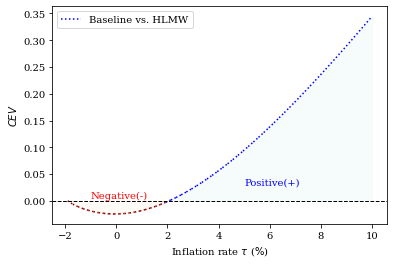

In [14]:
##### ZOOM-IN

##### plt.style.use(style='default')
plt.figure(facecolor='white')
# Initialize a flag to indicate when the label has been added
label_added_red = False
label_added_blue = False

for i in range(1, len(i_grid[0:60])):
    if Case1_cev[i-1] <= 0 and Case1_cev[i] > 0 or Case1_cev[i-1] > 0 and Case1_cev[i] > 0:
        # This segment is positive, plot in blue
        if not label_added_blue:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':', label='Baseline vs. HLMW')
            label_added_blue = True
        else:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':')
    else:
        # This segment is not positive, plot in dark red
        if not label_added_red:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')
            label_added_red = True
        else:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')


#plt.plot(i_grid[0:10]*100, np.zeros(τ_grid[0:30].size))
plt.ylabel("$CEV$")
plt.xlabel(r'Inflation rate $\tau$ ($\%$)')
plt.legend()
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.fill_between(model.τ_grid[0:]*100, Case1_cev[0:], where=(np.array(Case1_cev)[0:] <= 0), color='peachpuff', alpha=0.1, interpolate=True)
plt.fill_between(model.τ_grid[0:]*100, Case1_cev[0:], where=(np.array(Case1_cev)[0:] >= 0), color='#B0E0E6', alpha=0.1, interpolate=True)
plt.text(-1, 0.005, 'Negative(-)',size=10,color='red')
plt.text(5, 0.03, 'Positive(+)',size=10,color='blue')
#plt.ylim(-0.02,0.22)
plt.savefig("cev_zoom_in.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Additional Figure: Real balance($z$) in Baseline and HLMW economy

- The figure below illustrates the trend of real balances in the steady state of the baseline model and the HLMW economy as inflation($\gamma$) varies.

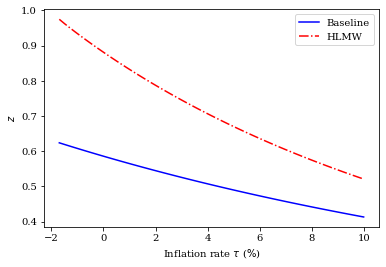

In [15]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), z[1:], color='blue', label='Baseline') #exclude FR
plt.plot(100*(model.τ_grid[1:]), z_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$z$')
plt.xlabel(r'Inflation rate $\tau$ ($\%$)')
plt.legend()
#plt.yticks(np.arange(1.19,1.3, 0.02))
#plt.xlim(-0.5,8)
plt.savefig("z.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Additional Figure: interest rate($i$) in Baseline

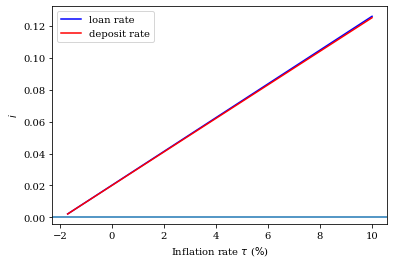

In [16]:
i = result['allocation_grid']['istar']
id = result['allocation_grid']['i_dstar']
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), i[1:], color='blue', label='loan rate') #exclude FR
plt.plot(100*(model.τ_grid[1:]), id[1:], color='red', label='deposit rate') #exclude FR
plt.axhline(model.i_r)
plt.ylabel(r'$i$')
plt.xlabel(r'Inflation rate $\tau$ ($\%$)')
plt.legend()
#plt.yticks(np.arange(1.19,1.3, 0.02))
#plt.xlim(-0.5,8)
plt.savefig("z.png", bbox_inches='tight', pad_inches=0.05)
plt.show()